<div>

> **Note**
>
> Code chunks run Python commands unless it starts with `%%bash`, in
> which case, those chunks run shell commands.

</div>

In this tutorial we will cover differential gene expression, which
comprises an extensive range of topics and methods. In single cell,
differential expresison can have multiple functionalities such as
identifying marker genes for cell populations, as well as identifying
differentially regulated genes across conditions (healthy vs control).
We will also cover controlling batch effect in your test.

Differential expression is performed with the function rank_genes_group.
The default method to compute differential expression is the
t-test_overestim_var. Other implemented methods are: logreg, t-test and
wilcoxon.

By default, the .raw attribute of AnnData is used in case it has been
initialized, it can be changed by setting use_raw=False.

The clustering with resolution 0.6 seems to give a reasonable number of
clusters, so we will use that clustering for all DE tests.

First, let's import libraries and fetch the clustered data from the
previous lab.

In [1]:
#| label: libraries
import numpy as np
import pandas as pd
import scanpy as sc
import gseapy
import matplotlib.pyplot as plt
import warnings
import os
import subprocess

warnings.simplefilter(action="ignore", category=Warning)

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 2

sc.settings.set_figure_params(dpi=80)

Read in the clustered data object.

In [2]:
#| label: fetch-data
# download pre-computed data if missing or long compute
fetch_data = True

# url for source and intermediate data
path_data = "https://nextcloud.dc.scilifelab.se/public.php/webdav"
curl_upass = "zbC5fr2LbEZ9rSE:scRNAseq2025"

path_results = "data/covid/results"
if not os.path.exists(path_results):
    os.makedirs(path_results, exist_ok=True)

# path_file = "data/covid/results/scanpy_covid_qc_dr_int_cl.h5ad"
path_file = "data/covid/results/scanpy_covid_qc_dr_int_cl.h5ad"
if fetch_data and not os.path.exists(path_file):
    file_url = os.path.join(path_data, "covid/results_scanpy/scanpy_covid_qc_dr_int_cl.h5ad")
    subprocess.call(["curl", "-u", curl_upass, "-o", path_file, file_url ])

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 7332 × 3984
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden', 'leiden_0.4', 'leiden_0.6', 'leiden_1.0', 'leiden_1.4', 'kmeans5', 'kmeans10', 'kmeans15', 'hclust_5', 'hclust_10', 'hclust_15'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'dendrogram_leiden_0.6', 'doublet_info_colors', 'hclust_10_colors', 'hclust_15_colors', 'hclust_5_colors', 'hvg', 'kmeans10_colors', 'kmeans15_colors', 'kmeans5_colors'

Check what you have in the different matrices.

In [3]:
#| label: check-data
print(adata.X.shape)
print(type(adata.raw))
print(adata.X[:10,:10])

(7332, 3984)
<class 'anndata._core.raw.Raw'>
[[-0.17232972 -0.54321549 -0.31634794 -0.90417343 -0.16910255 -0.05583347
  -0.25571551 -0.20106716 -0.07050795 -0.35735729]
 [ 5.54532801 -0.54321549 -0.31634794 -0.90417343 -0.16910255 -0.05583347
  -0.25571551 -0.20106716 -0.07050795 -0.35735729]
 [-0.17232972 -0.54321549 -0.31634794  0.17987218 -0.16910255 -0.05583347
  -0.25571551 -0.20106716 -0.07050795 -0.35735729]
 [-0.17232972 -0.54321549 -0.31634794 -0.90417343 -0.16910255 -0.05583347
  -0.25571551  6.01645508 -0.07050795 -0.35735729]
 [-0.17232972 -0.54321549 -0.31634794 -0.90417343 -0.16910255 -0.05583347
  -0.25571551 -0.20106716 -0.07050795 -0.35735729]
 [-0.17232972 -0.54321549 -0.31634794 -0.90417343 -0.16910255 -0.05583347
  -0.25571551 -0.20106716 -0.07050795 -0.35735729]
 [-0.17232972 -0.54321549 -0.31634794 -0.90417343 -0.16910255 -0.05583347
  -0.25571551 -0.20106716 -0.07050795 -0.35735729]
 [-0.17232972 -0.54321549 -0.31634794 -0.90417343 -0.16910255 -0.05583347
  -0.2

As you can see, the X matrix contains all genes and the data looks
logtransformed.

For DGE analysis we would like to run with all genes, on normalized
values, so if you did subset the `adata.X` for variable genes you would
have to revert back to the raw matrix with
`adata = adata.raw.to_adata()`. In case you have raw counts in the
matrix you also have to renormalize and logtransform.

Now lets look at the clustering of the object we loaded in the umap. We
will use leiden_0.6 clustering in this exercise. If you recall from the
previous exercise, we set the default umap to the umap created with
Harmony.

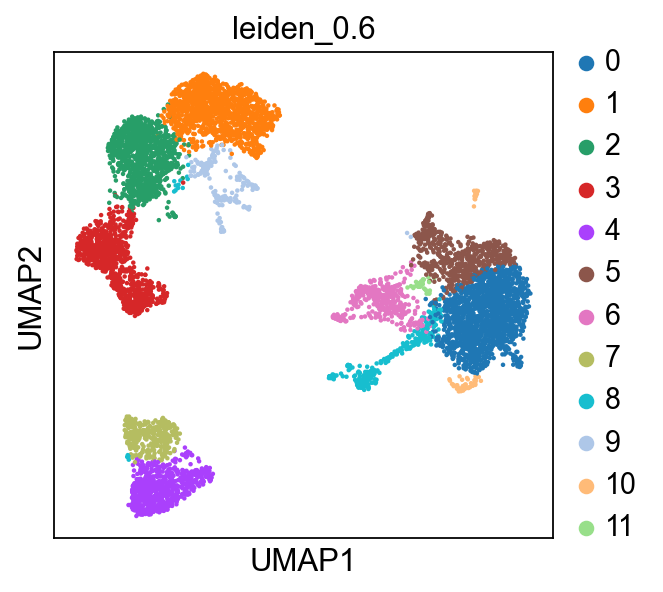

In [4]:
#| label: plot-umap
sc.pl.umap(adata, color='leiden_0.6')

## T-test

ranking genes
    finished (0:00:00)


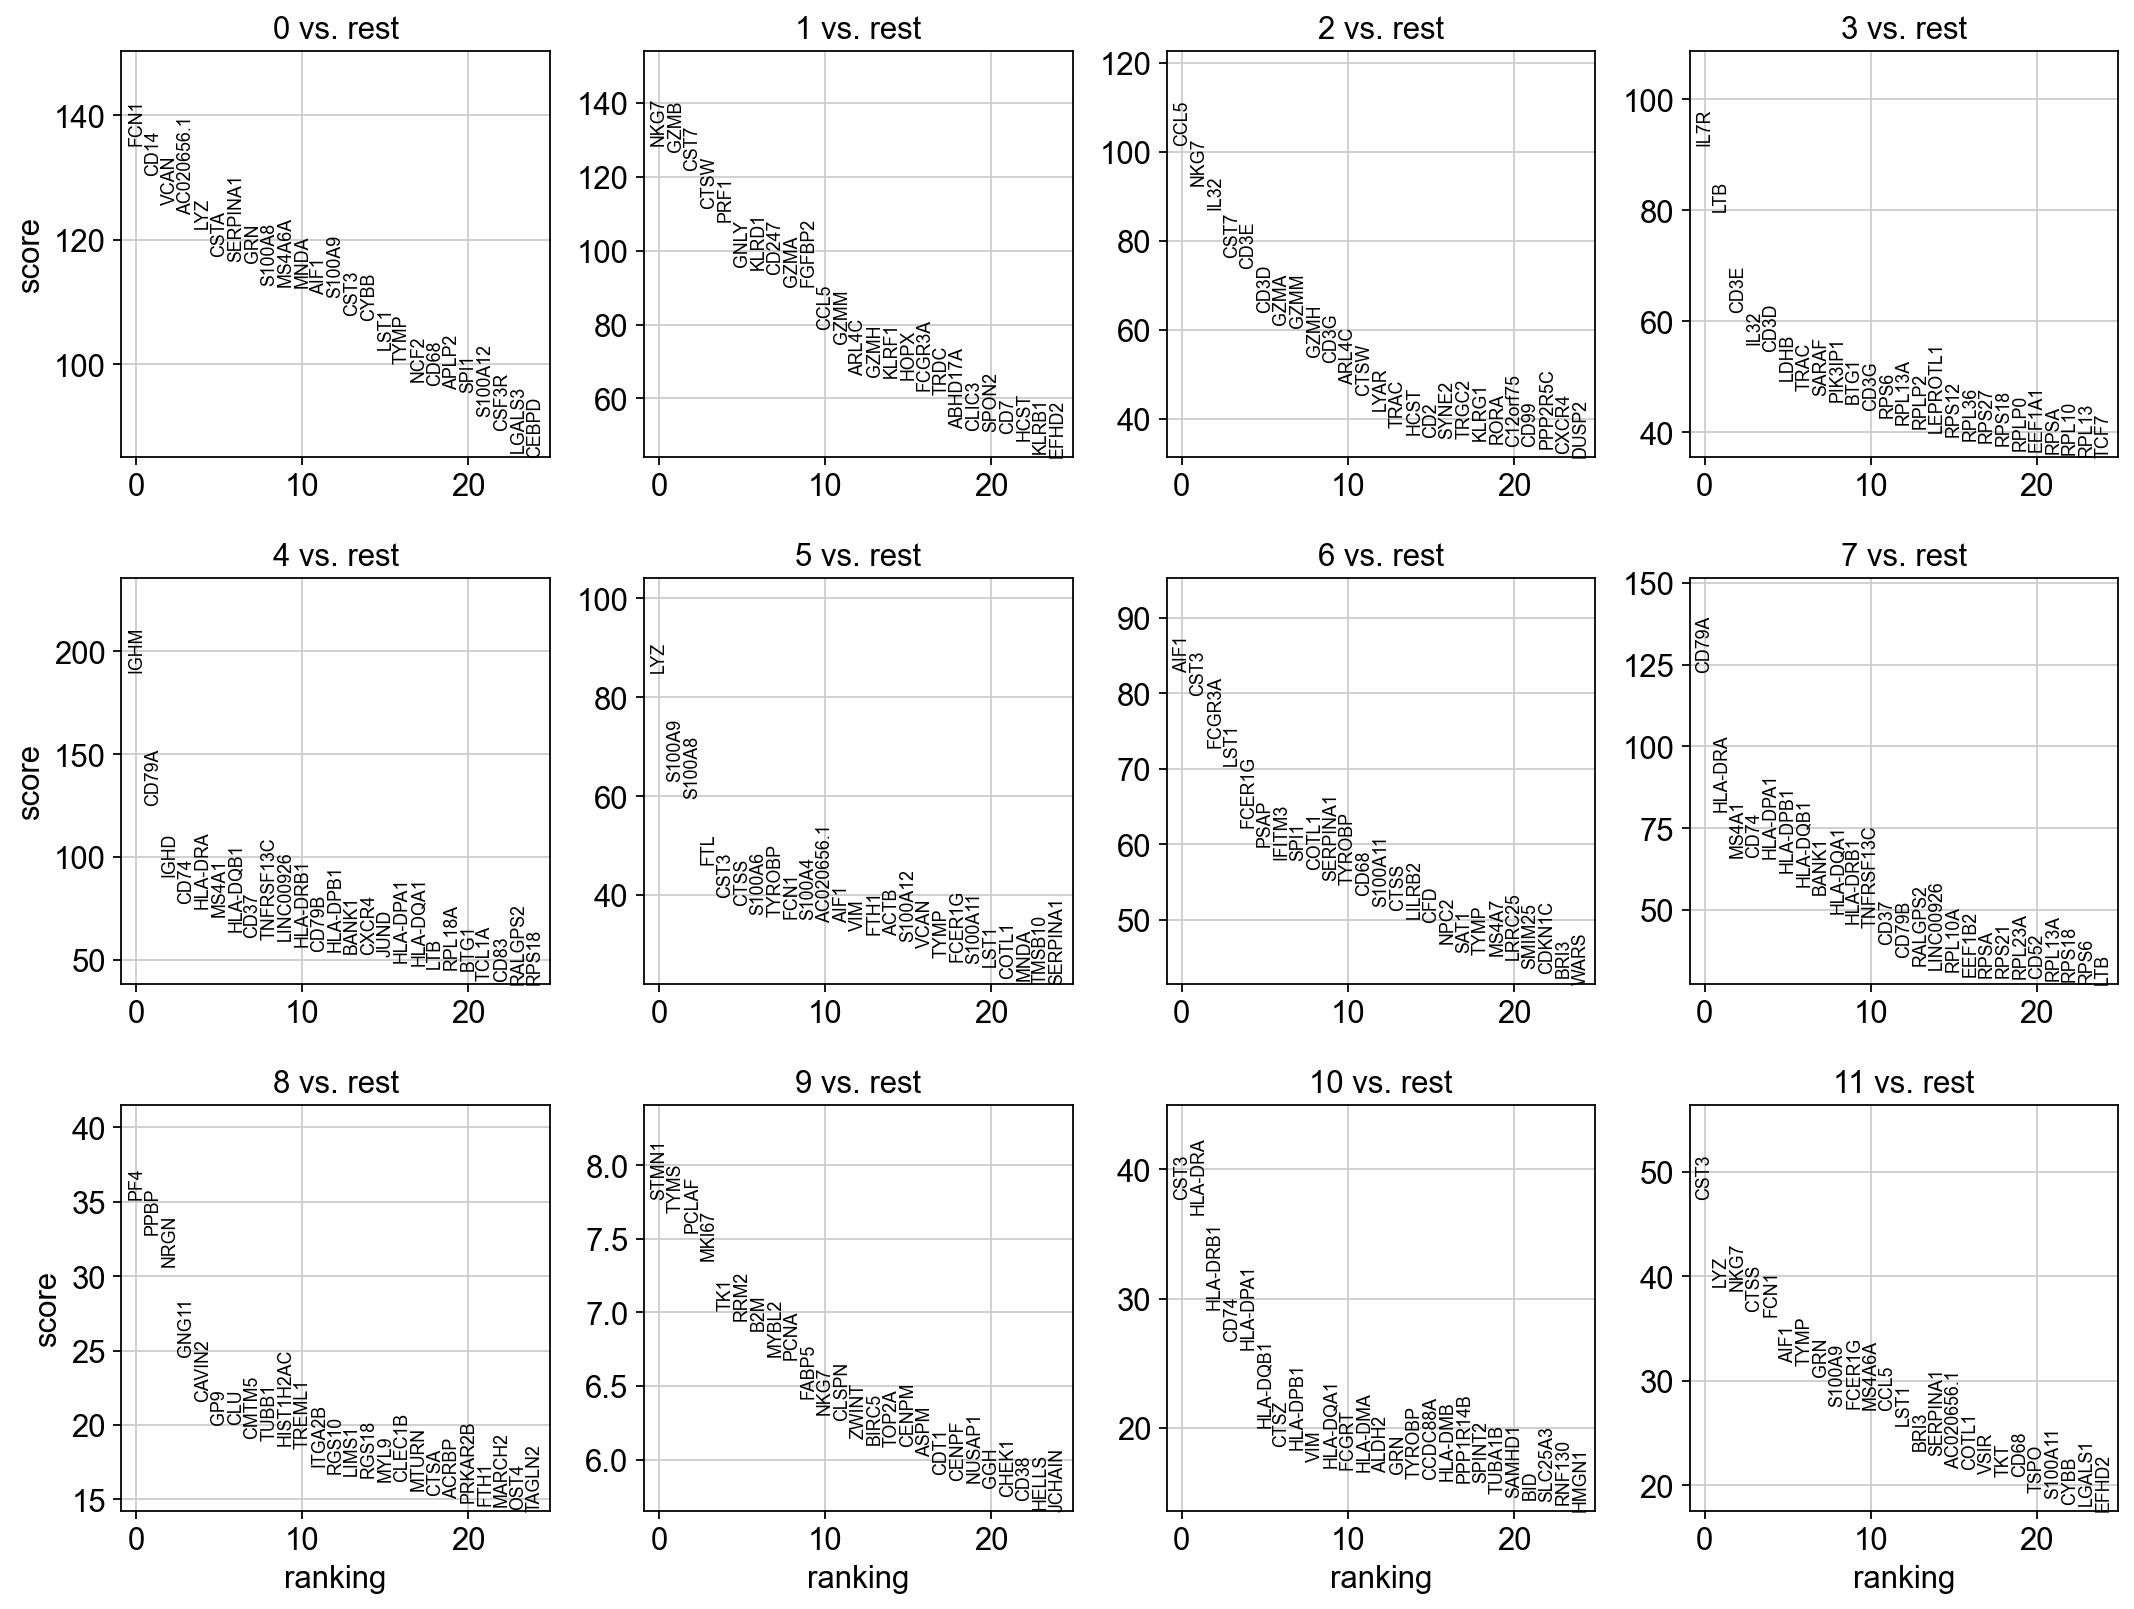

dict_keys(['dendrogram_leiden_0.6', 'doublet_info_colors', 'hclust_10_colors', 'hclust_15_colors', 'hclust_5_colors', 'hvg', 'kmeans10_colors', 'kmeans15_colors', 'kmeans5_colors', 'leiden', 'leiden_0.4', 'leiden_0.4_colors', 'leiden_0.6', 'leiden_0.6_colors', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.4', 'leiden_1.4_colors', 'log1p', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'tsne', 'umap', 't-test'])

In [5]:
#| label: ttest
sc.tl.rank_genes_groups(adata, 'leiden_0.6', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test")

# results are stored in the adata.uns["t-test"] slot
adata.uns.keys()

## T-test overestimated_variance

ranking genes
    finished (0:00:00)


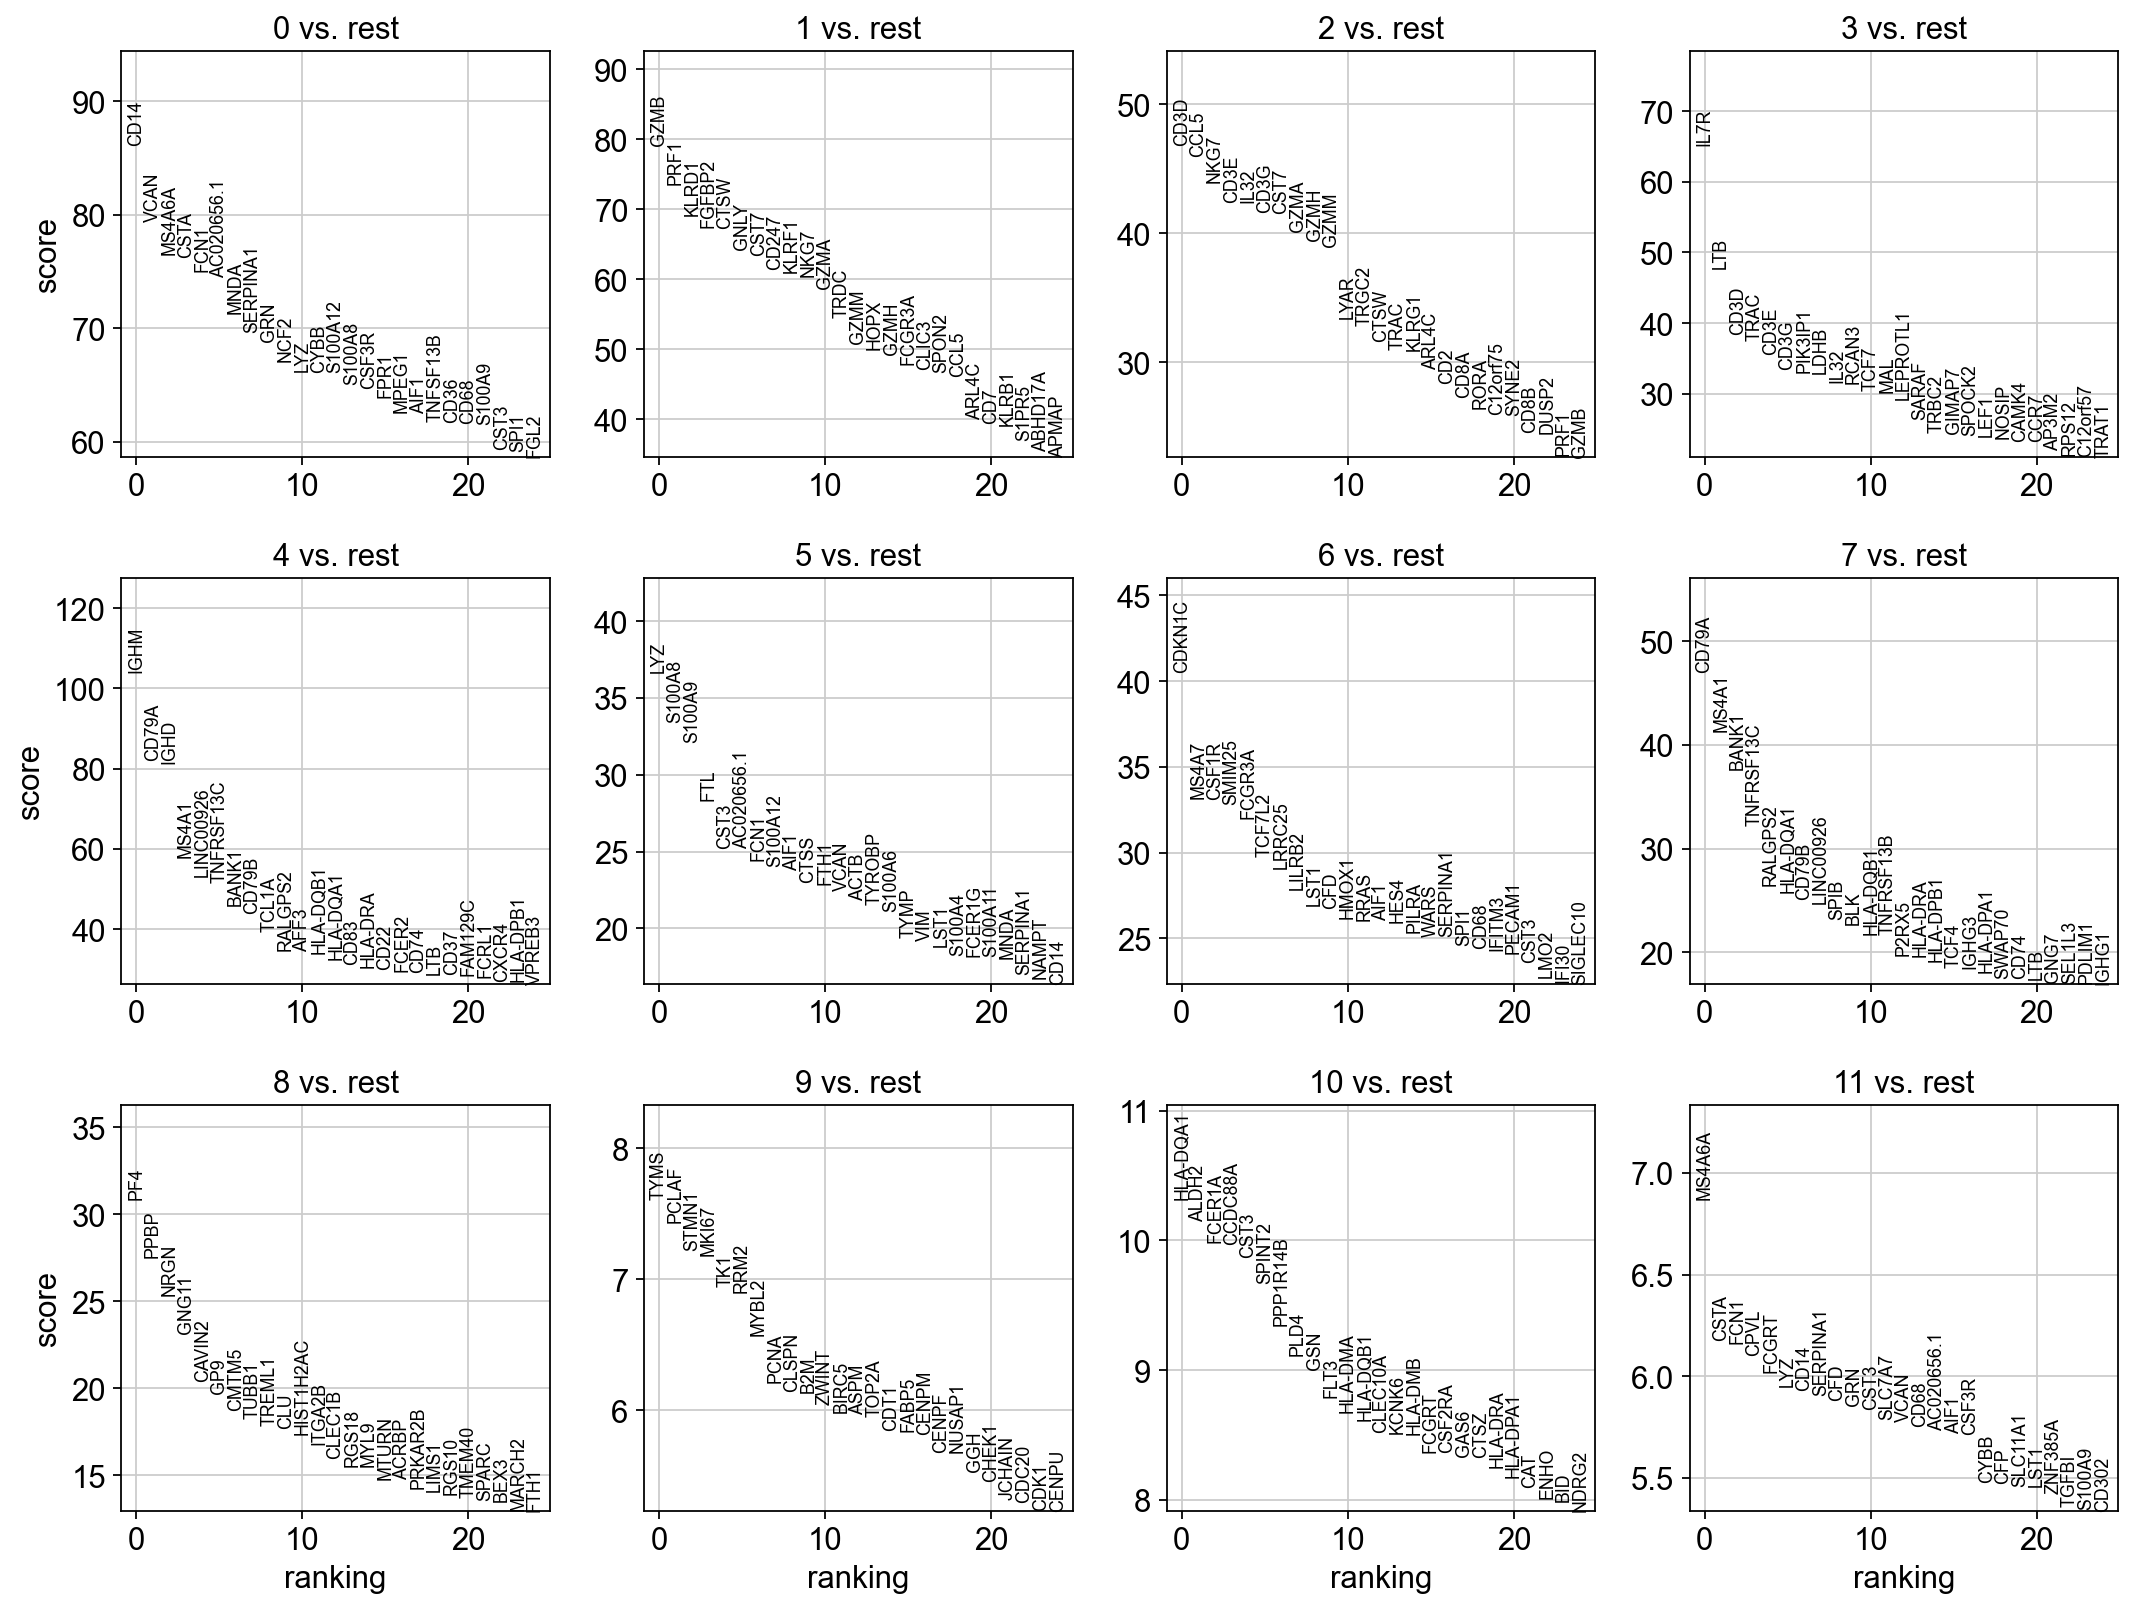

In [6]:
#| label: ttest-o
sc.tl.rank_genes_groups(adata, 'leiden_0.6', method='t-test_overestim_var', key_added = "t-test_ov")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test_ov")

## Wilcoxon rank-sum

The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar.
We recommend using the latter in publications, see e.g., Sonison &
Robinson (2018). You might also consider much more powerful differential
testing packages like MAST, limma, DESeq2 and, for python, the recent
diffxpy.

ranking genes
    finished (0:00:03)


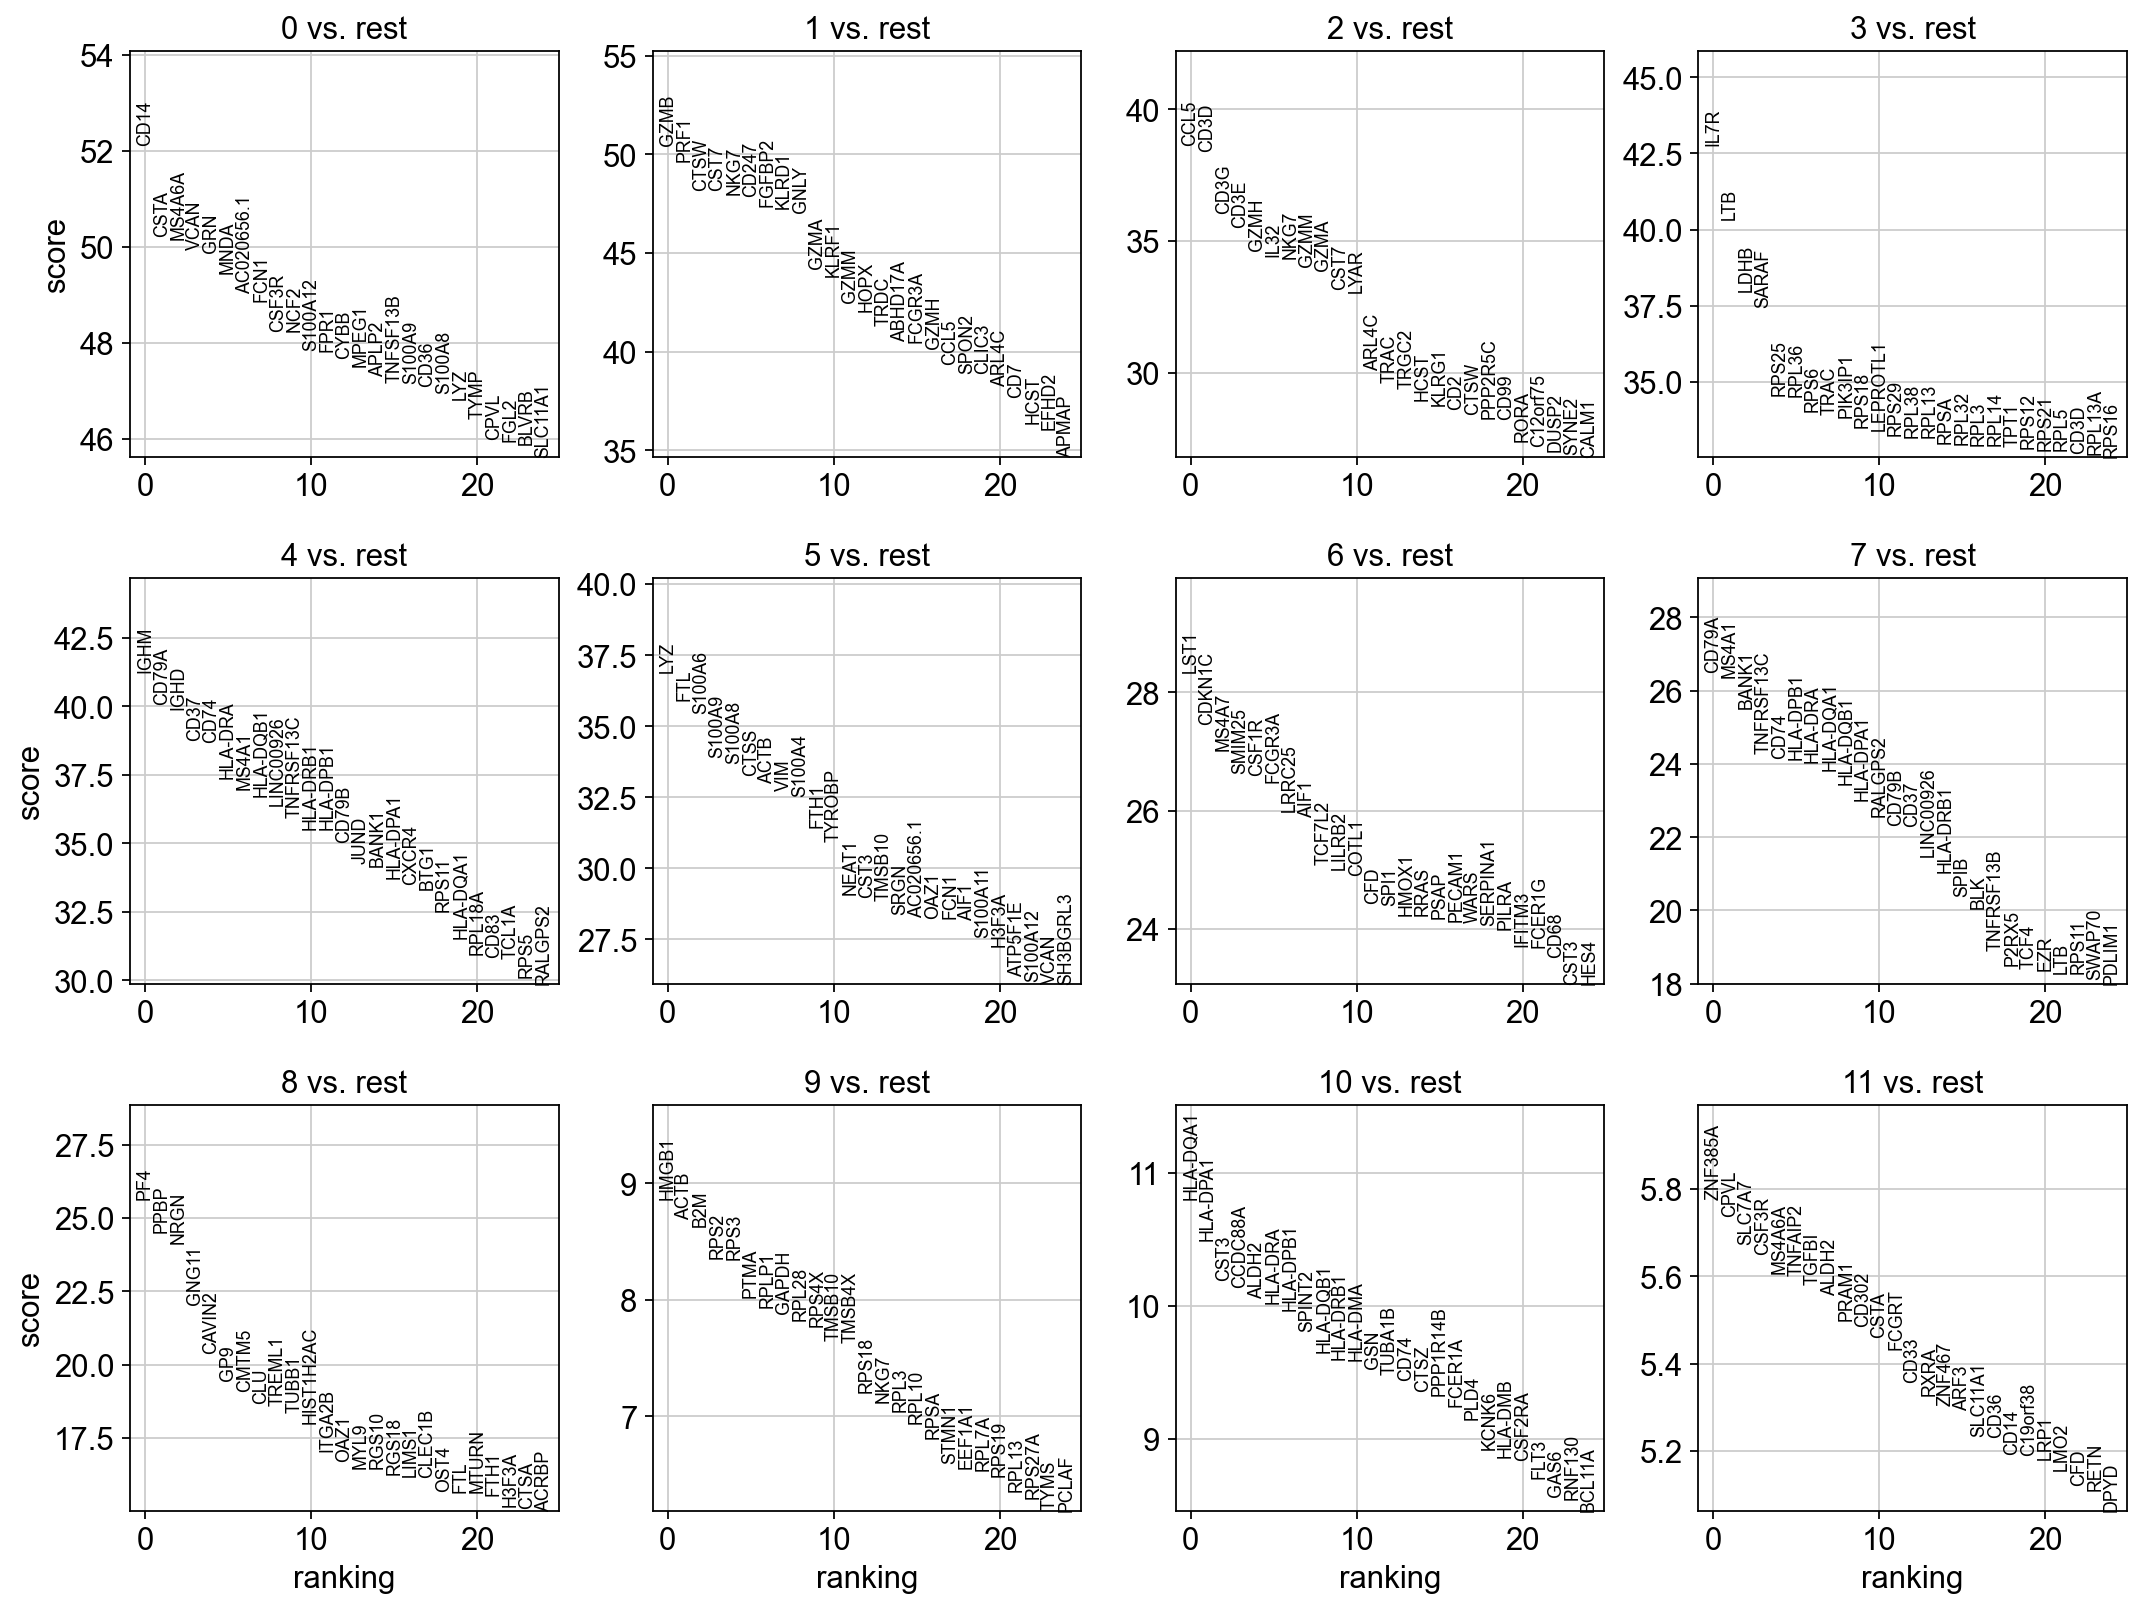

In [7]:
#| label: wilcoxon
sc.tl.rank_genes_groups(adata, 'leiden_0.6', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon")

## Logistic regression test

As an alternative, let us rank genes using logistic regression. For
instance, this has been suggested by Natranos et al. (2018). The
essential difference is that here, we use a multi-variate appraoch
whereas conventional differential tests are uni-variate. Clark et
al. (2014) has more details.

ranking genes
    finished (0:00:07)


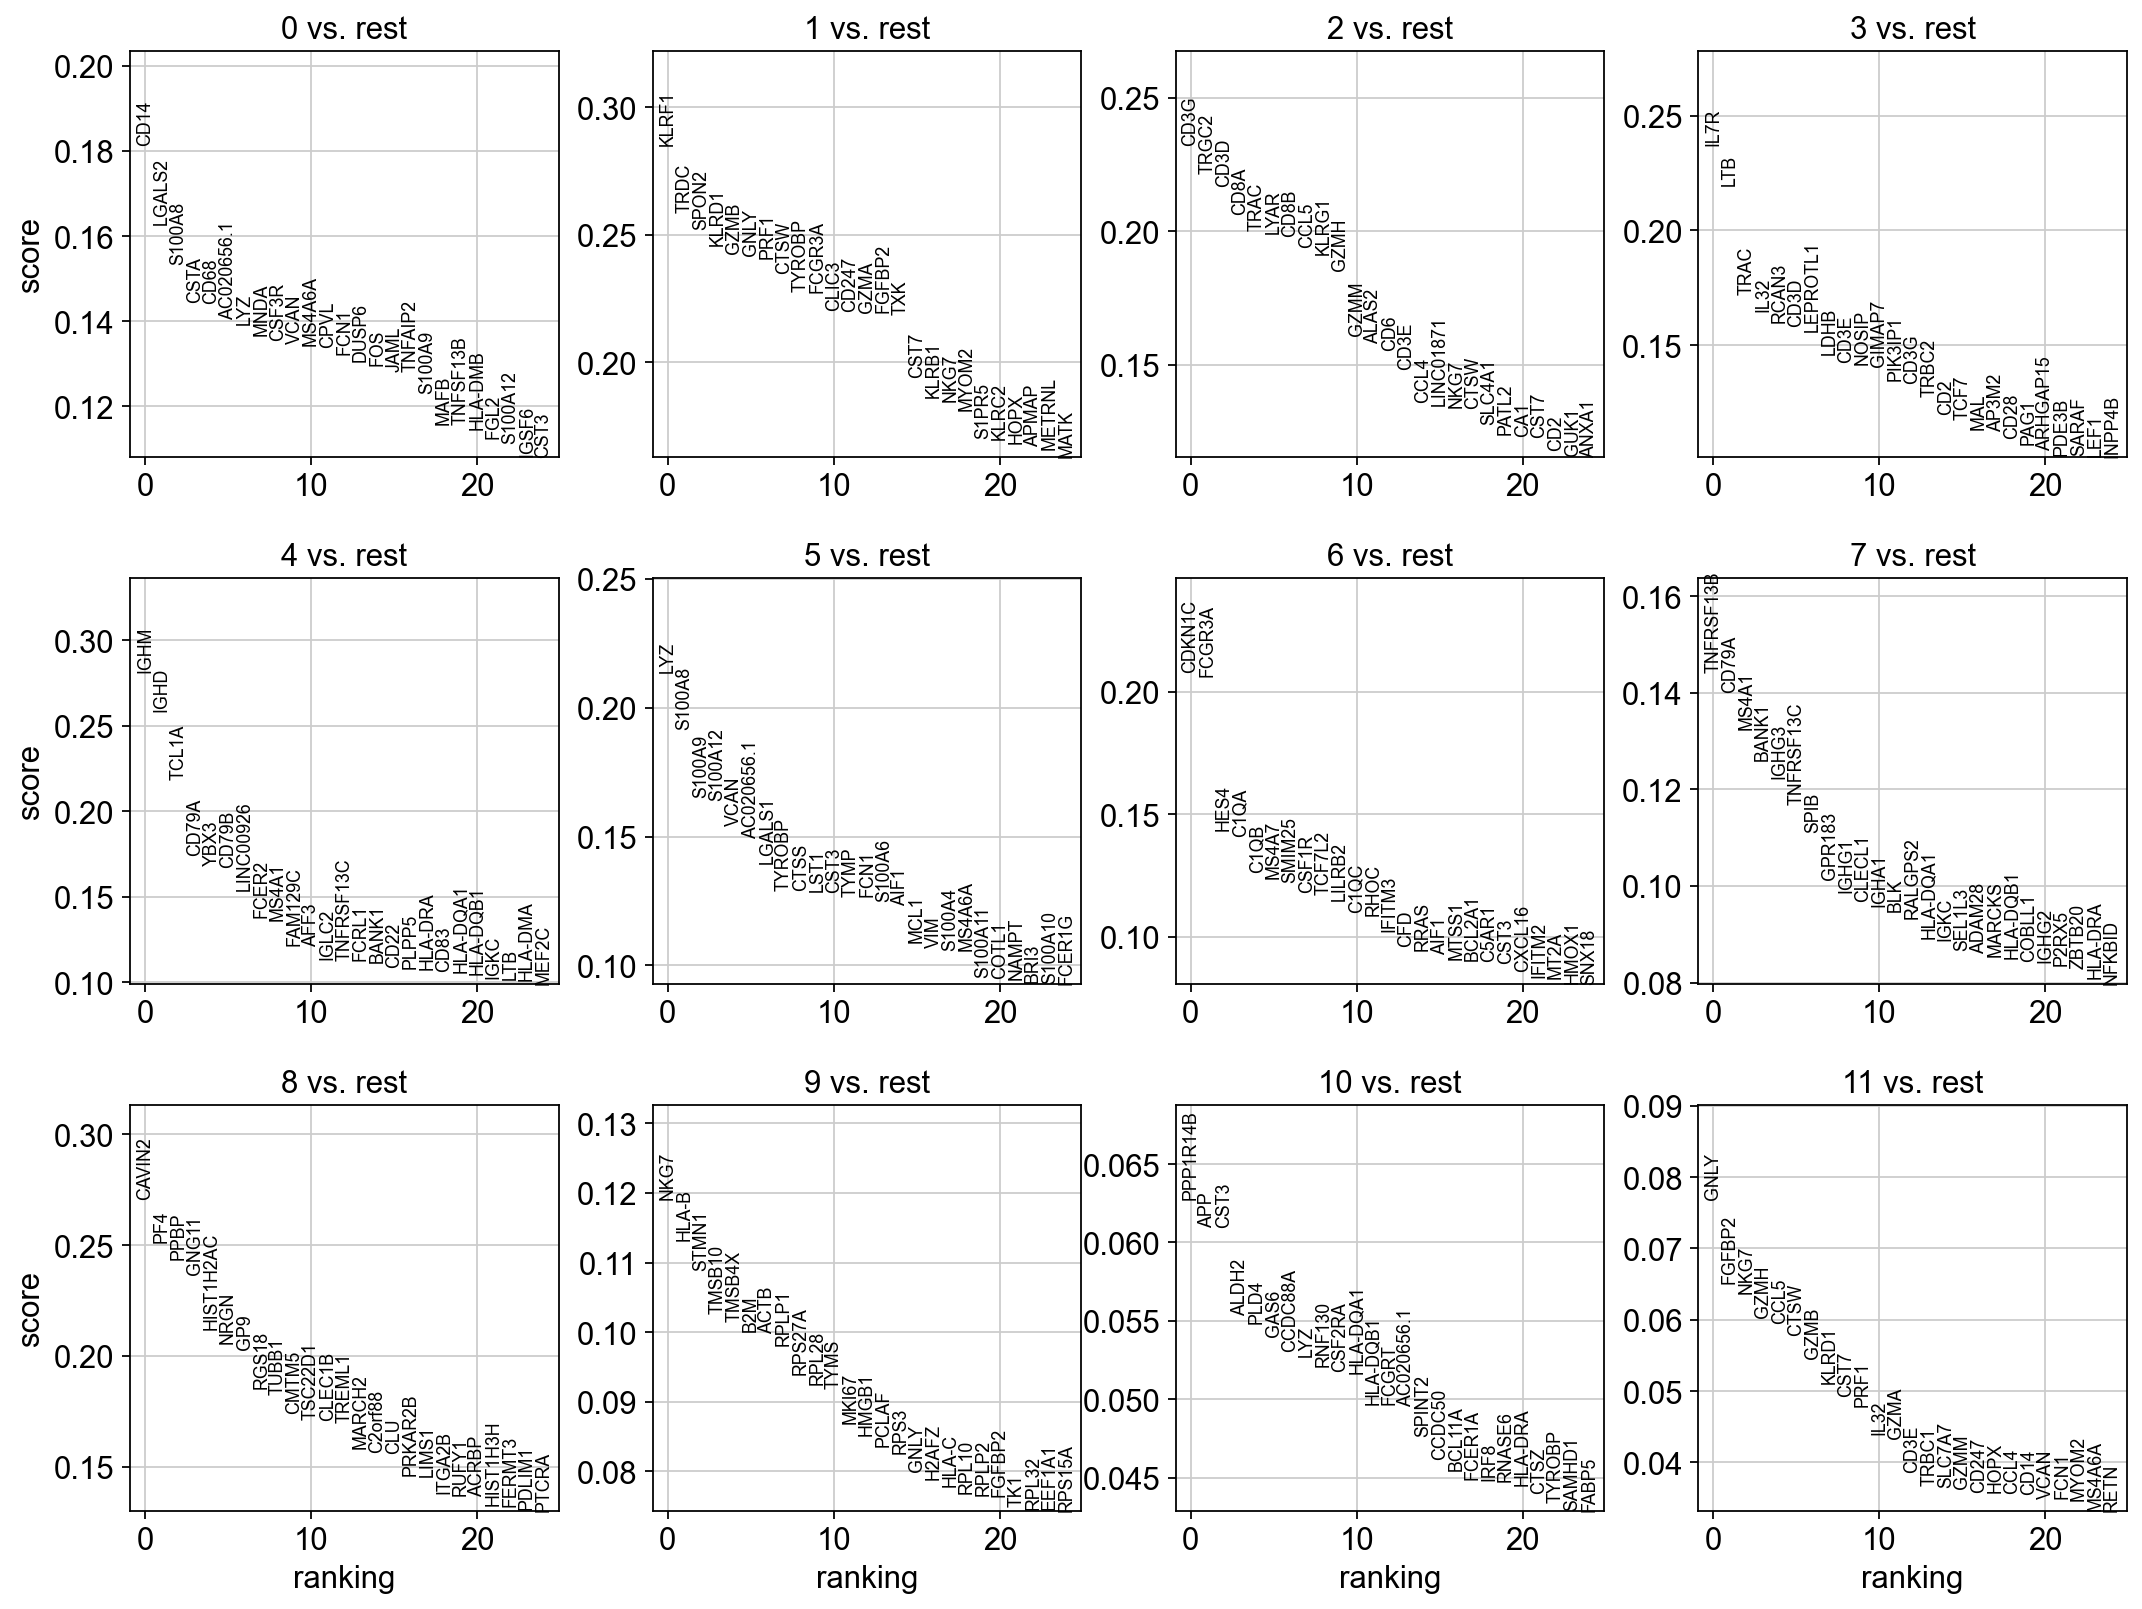

In [8]:
#| label: logreg
sc.tl.rank_genes_groups(adata, 'leiden_0.6', method='logreg',key_added = "logreg")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg")

## Compare genes

Take all significant DE genes for cluster0 with each test and compare
the overlap.

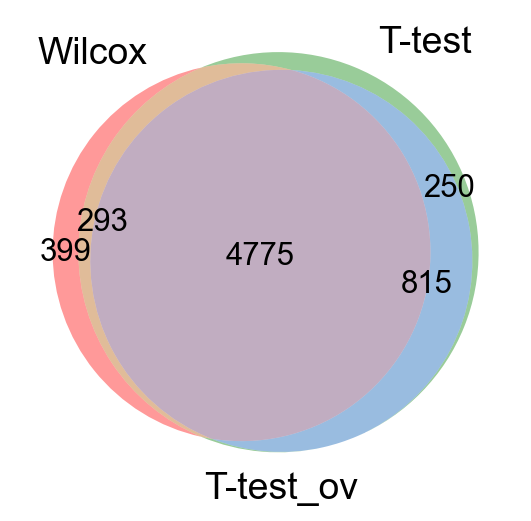

In [10]:
#| label: compare
#compare cluster1 genes, only stores top 100 by default

wc = sc.get.rank_genes_groups_df(adata, group='0', key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(adata, group='0', key='t-test', pval_cutoff=0.01, log2fc_min=0)['names']
tt_ov = sc.get.rank_genes_groups_df(adata, group='0', key='t-test_ov', pval_cutoff=0.01, log2fc_min=0)['names']

from matplotlib_venn import venn3

venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox','T-test','T-test_ov') )
plt.show()

As you can see, the Wilcoxon test and the T-test with overestimated
variance gives very similar result. Also the regular T-test has good
overlap.

## Visualization

There are several ways to visualize the expression of top DE genes. Here
we will plot top 5 genes per cluster from Wilcoxon test as heatmap,
dotplot, violin plots or a matrix with average expression.

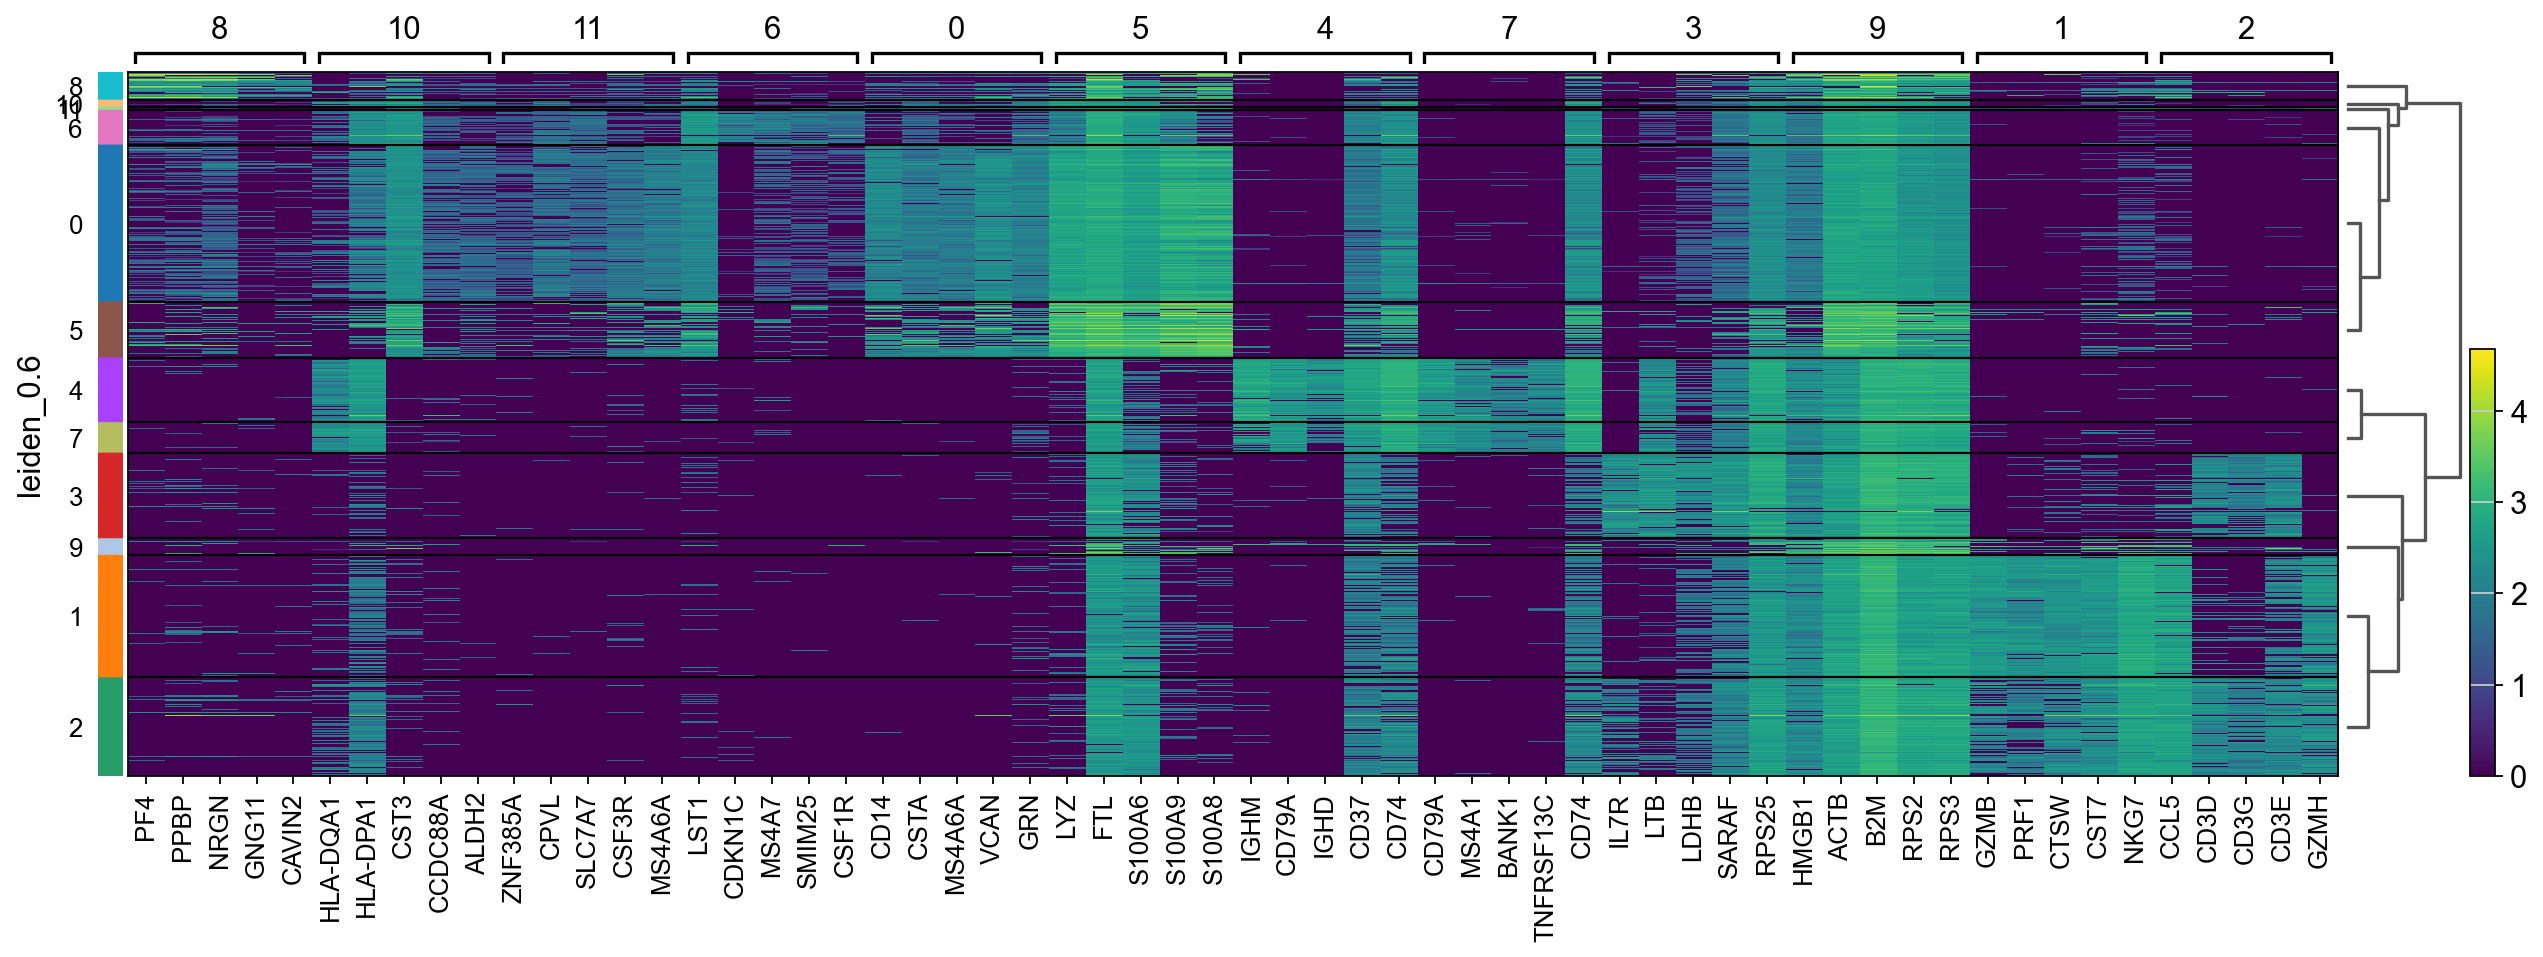

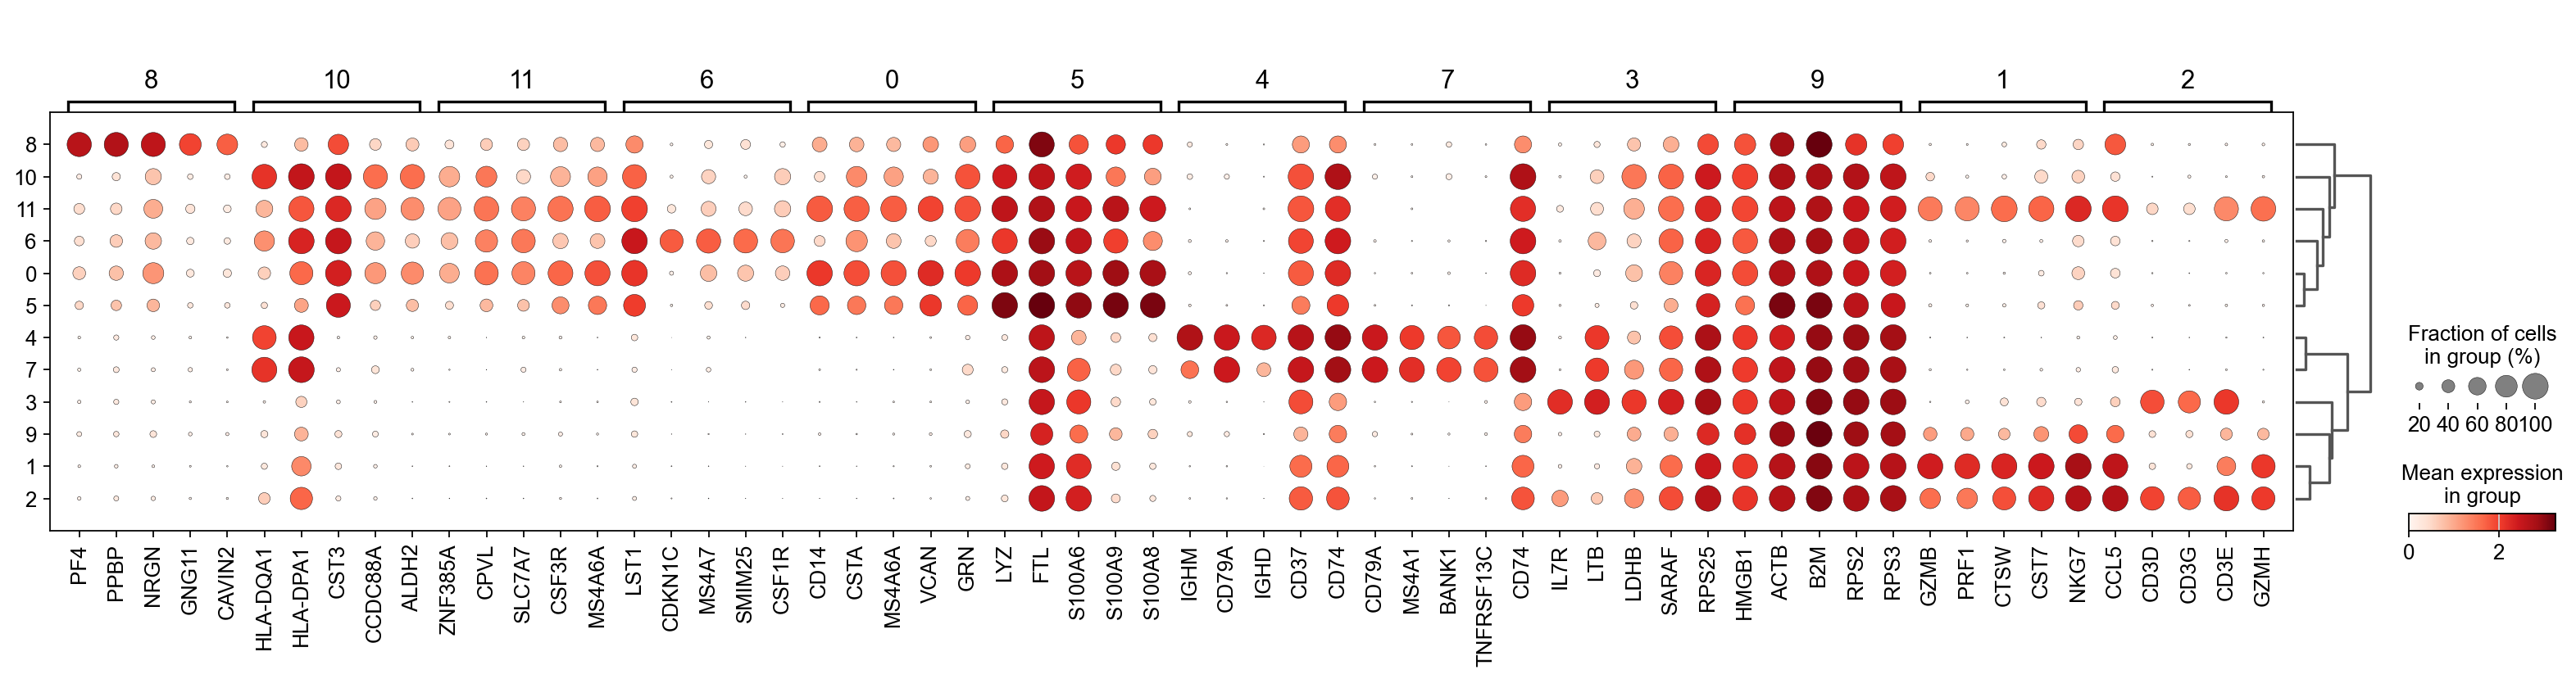

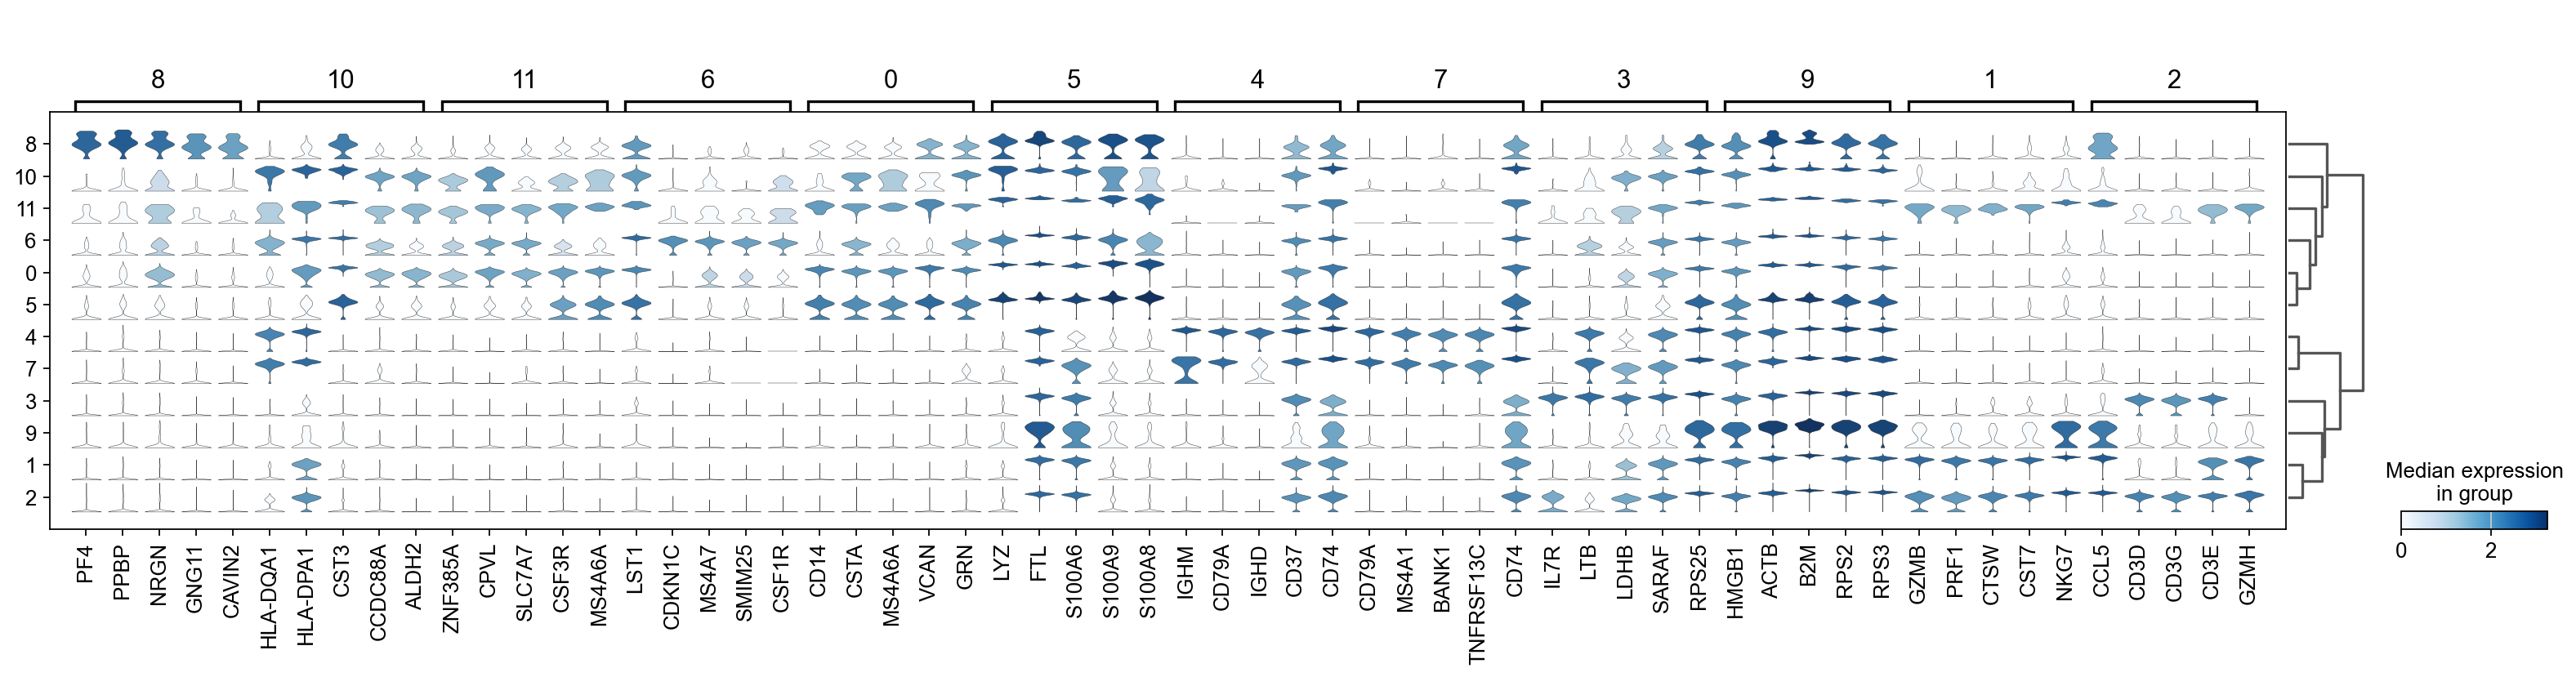

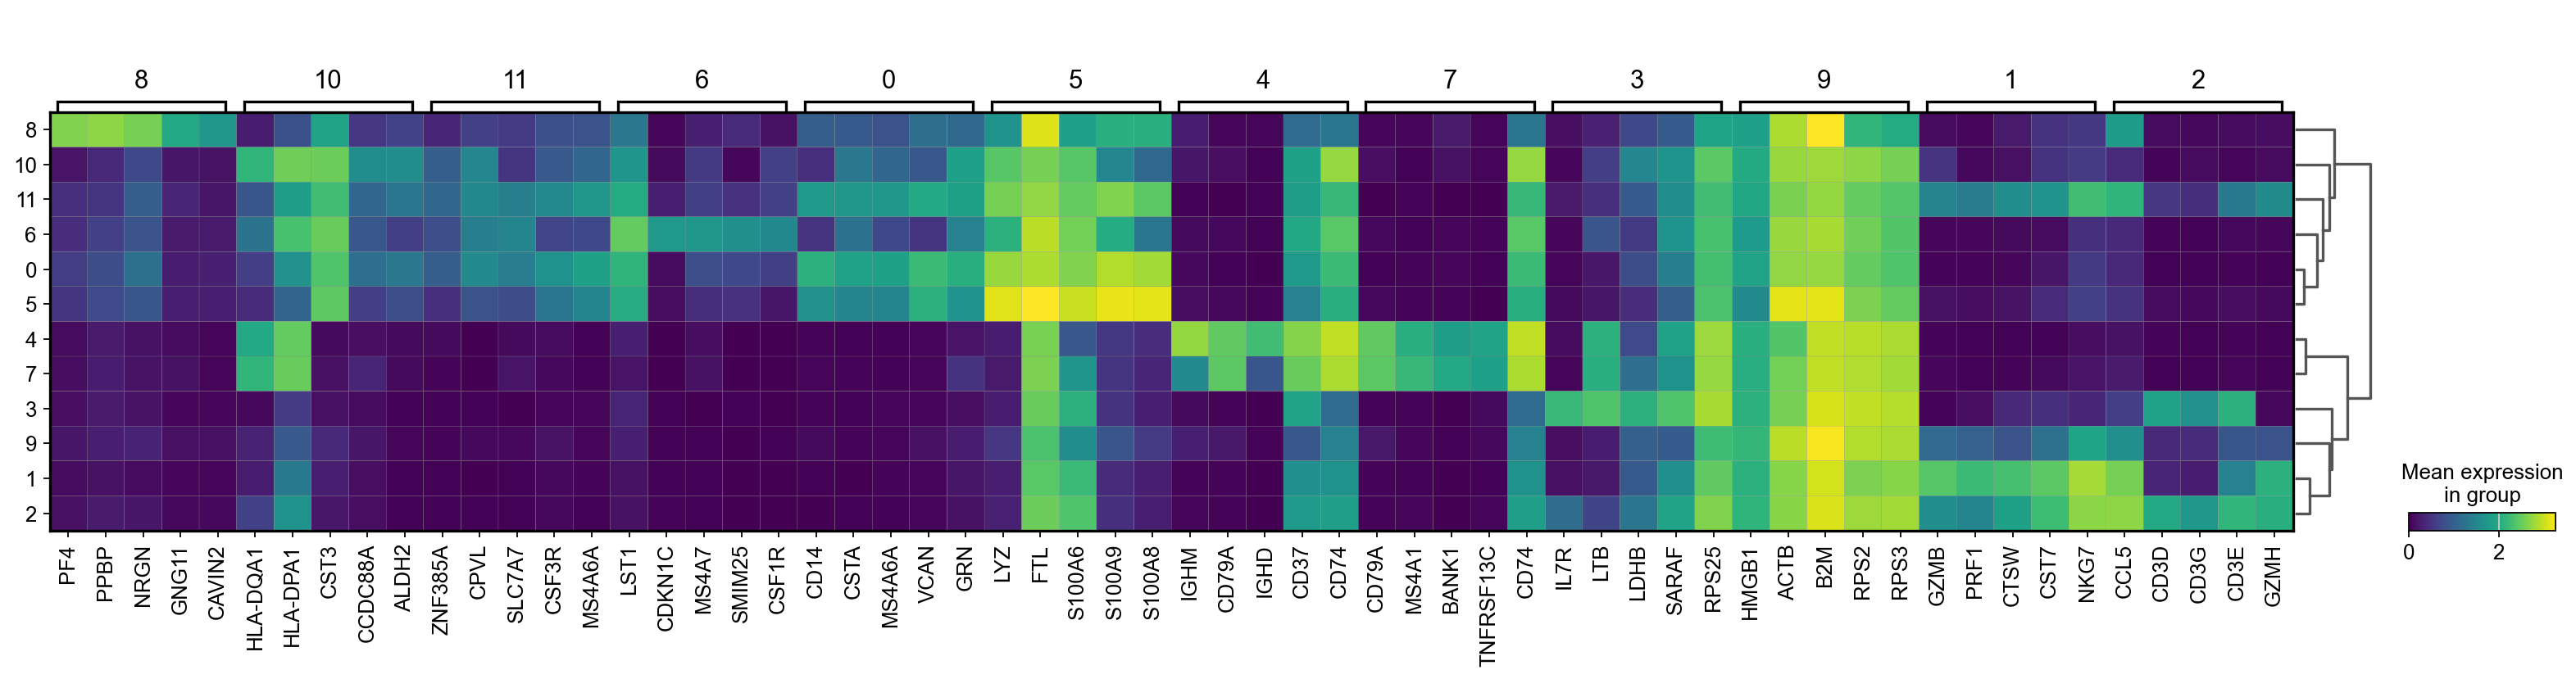

In [11]:
#| label: visualize
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby="leiden_0.6", show_gene_labels=True)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key="wilcoxon", groupby="leiden_0.6")
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, key="wilcoxon", groupby="leiden_0.6")
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="wilcoxon", groupby="leiden_0.6")

## Compare specific clusters

We can also do pairwise comparisons of individual clusters on one vs
many clusters. For instance, clusters 1 & 2 have very similar expression
profiles.

ranking genes
    finished (0:00:00)


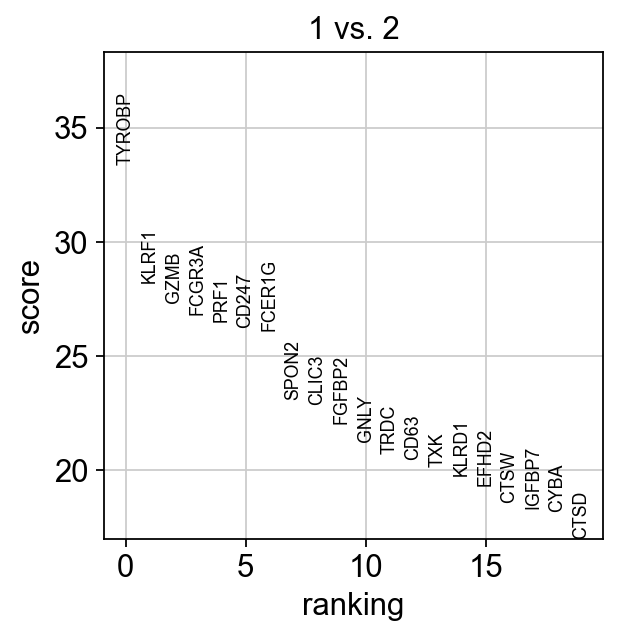

In [12]:
#| label: subset
sc.tl.rank_genes_groups(adata, 'leiden_0.6', groups=['1'], reference='2', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['1'], n_genes=20)

Plot as violins for those two groups, or across all the clusters.

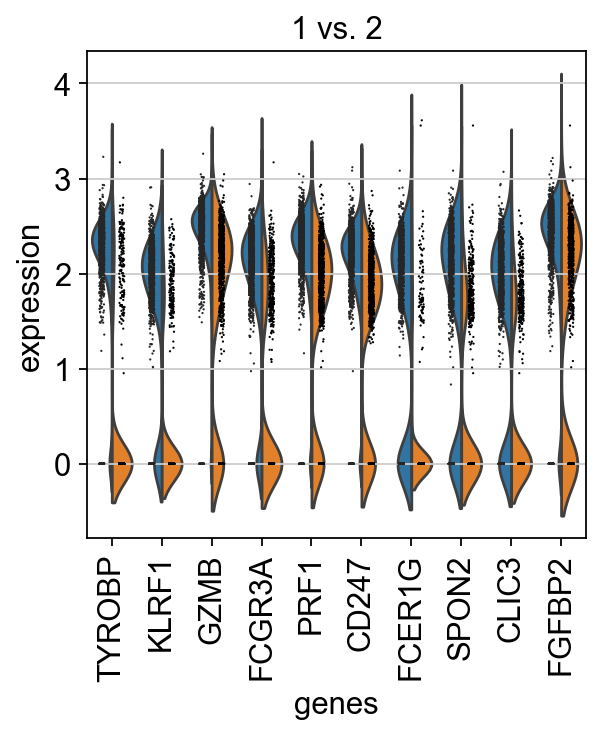

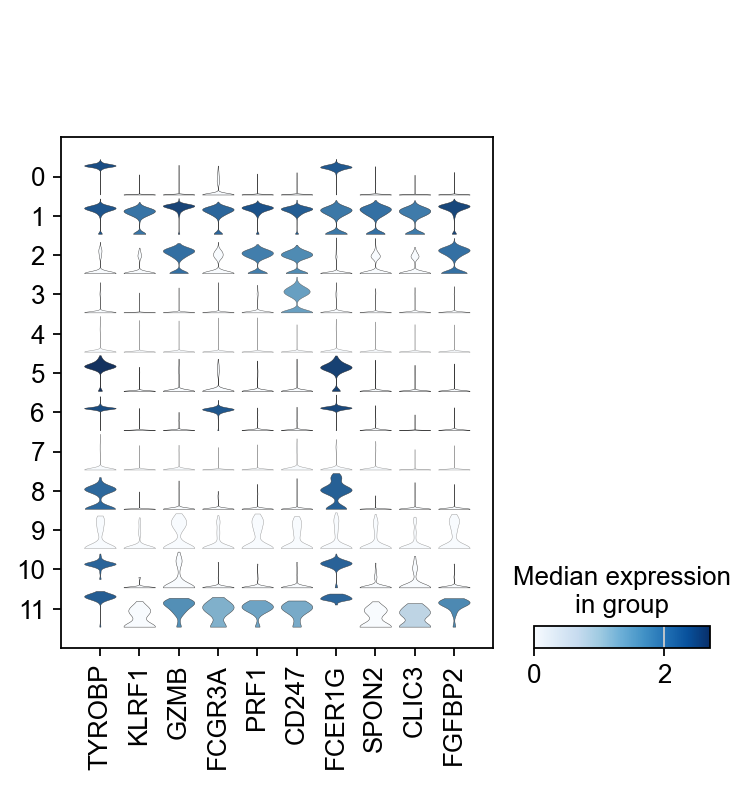

In [13]:
#| label: plot-subset
sc.pl.rank_genes_groups_violin(adata, groups='1', n_genes=10)

# plot the same genes as violins across all the datasets.

# convert numpy.recarray to list
mynames = [x[0] for x in adata.uns['rank_genes_groups']['names'][:10]]
sc.pl.stacked_violin(adata, mynames, groupby = 'leiden_0.6')

## DGE across conditions

The second way of computing differential expression is to answer which
genes are differentially expressed within a cluster. For example, in our
case we have libraries comming from patients and controls and we would
like to know which genes are influenced the most in a particular cell
type. For this end, we will first subset our data for the desired cell
cluster, then change the cell identities to the variable of comparison
(which now in our case is the **type**, e.g. Covid/Ctrl).

ranking genes
    finished (0:00:00)


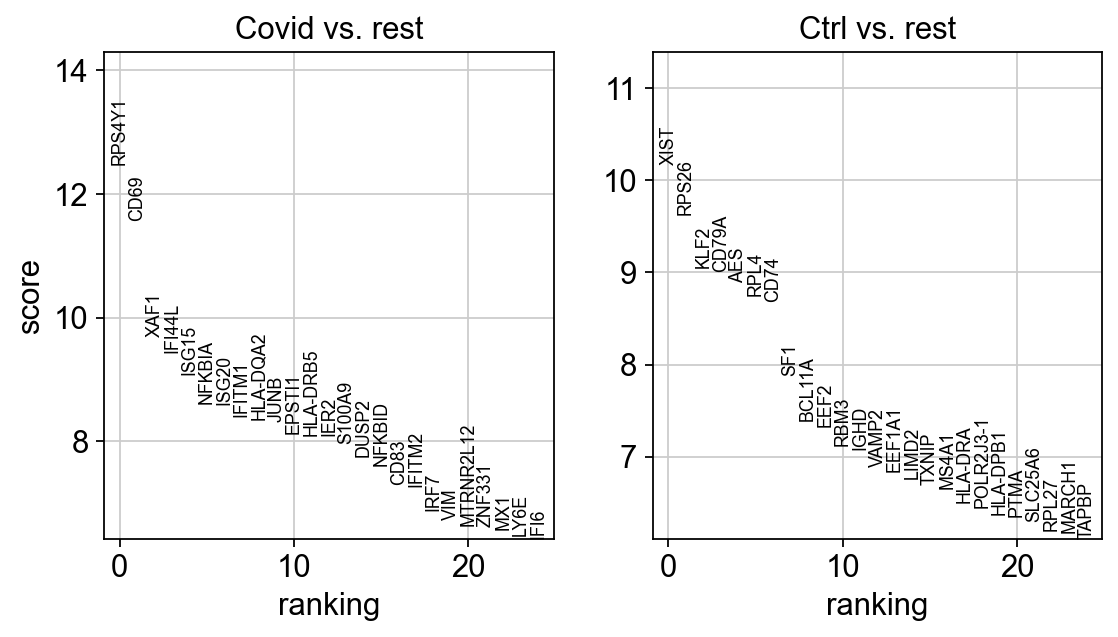

In [14]:
#| label: condition
cl1 = adata[adata.obs['leiden_0.6'] == '4',:]
cl1.obs['type'].value_counts()

sc.tl.rank_genes_groups(cl1, 'type', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False, key="wilcoxon")

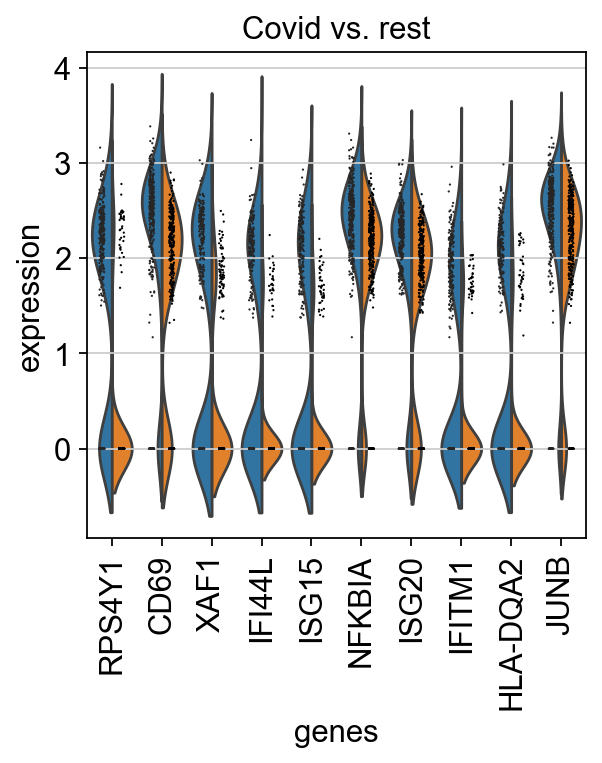

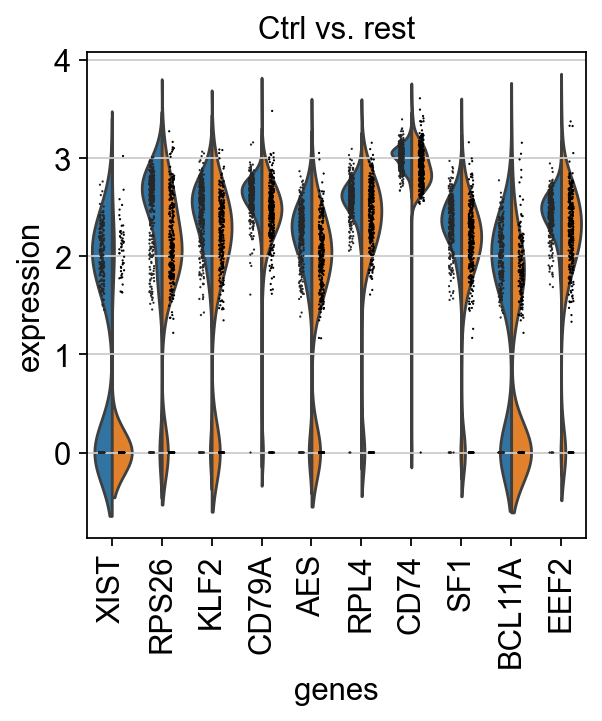

In [15]:
#| label: condition-vln
sc.pl.rank_genes_groups_violin(cl1, n_genes=10, key="wilcoxon")

We can also plot these genes across all clusters, but split by "type",
to check if the genes are also up/downregulated in other celltypes.

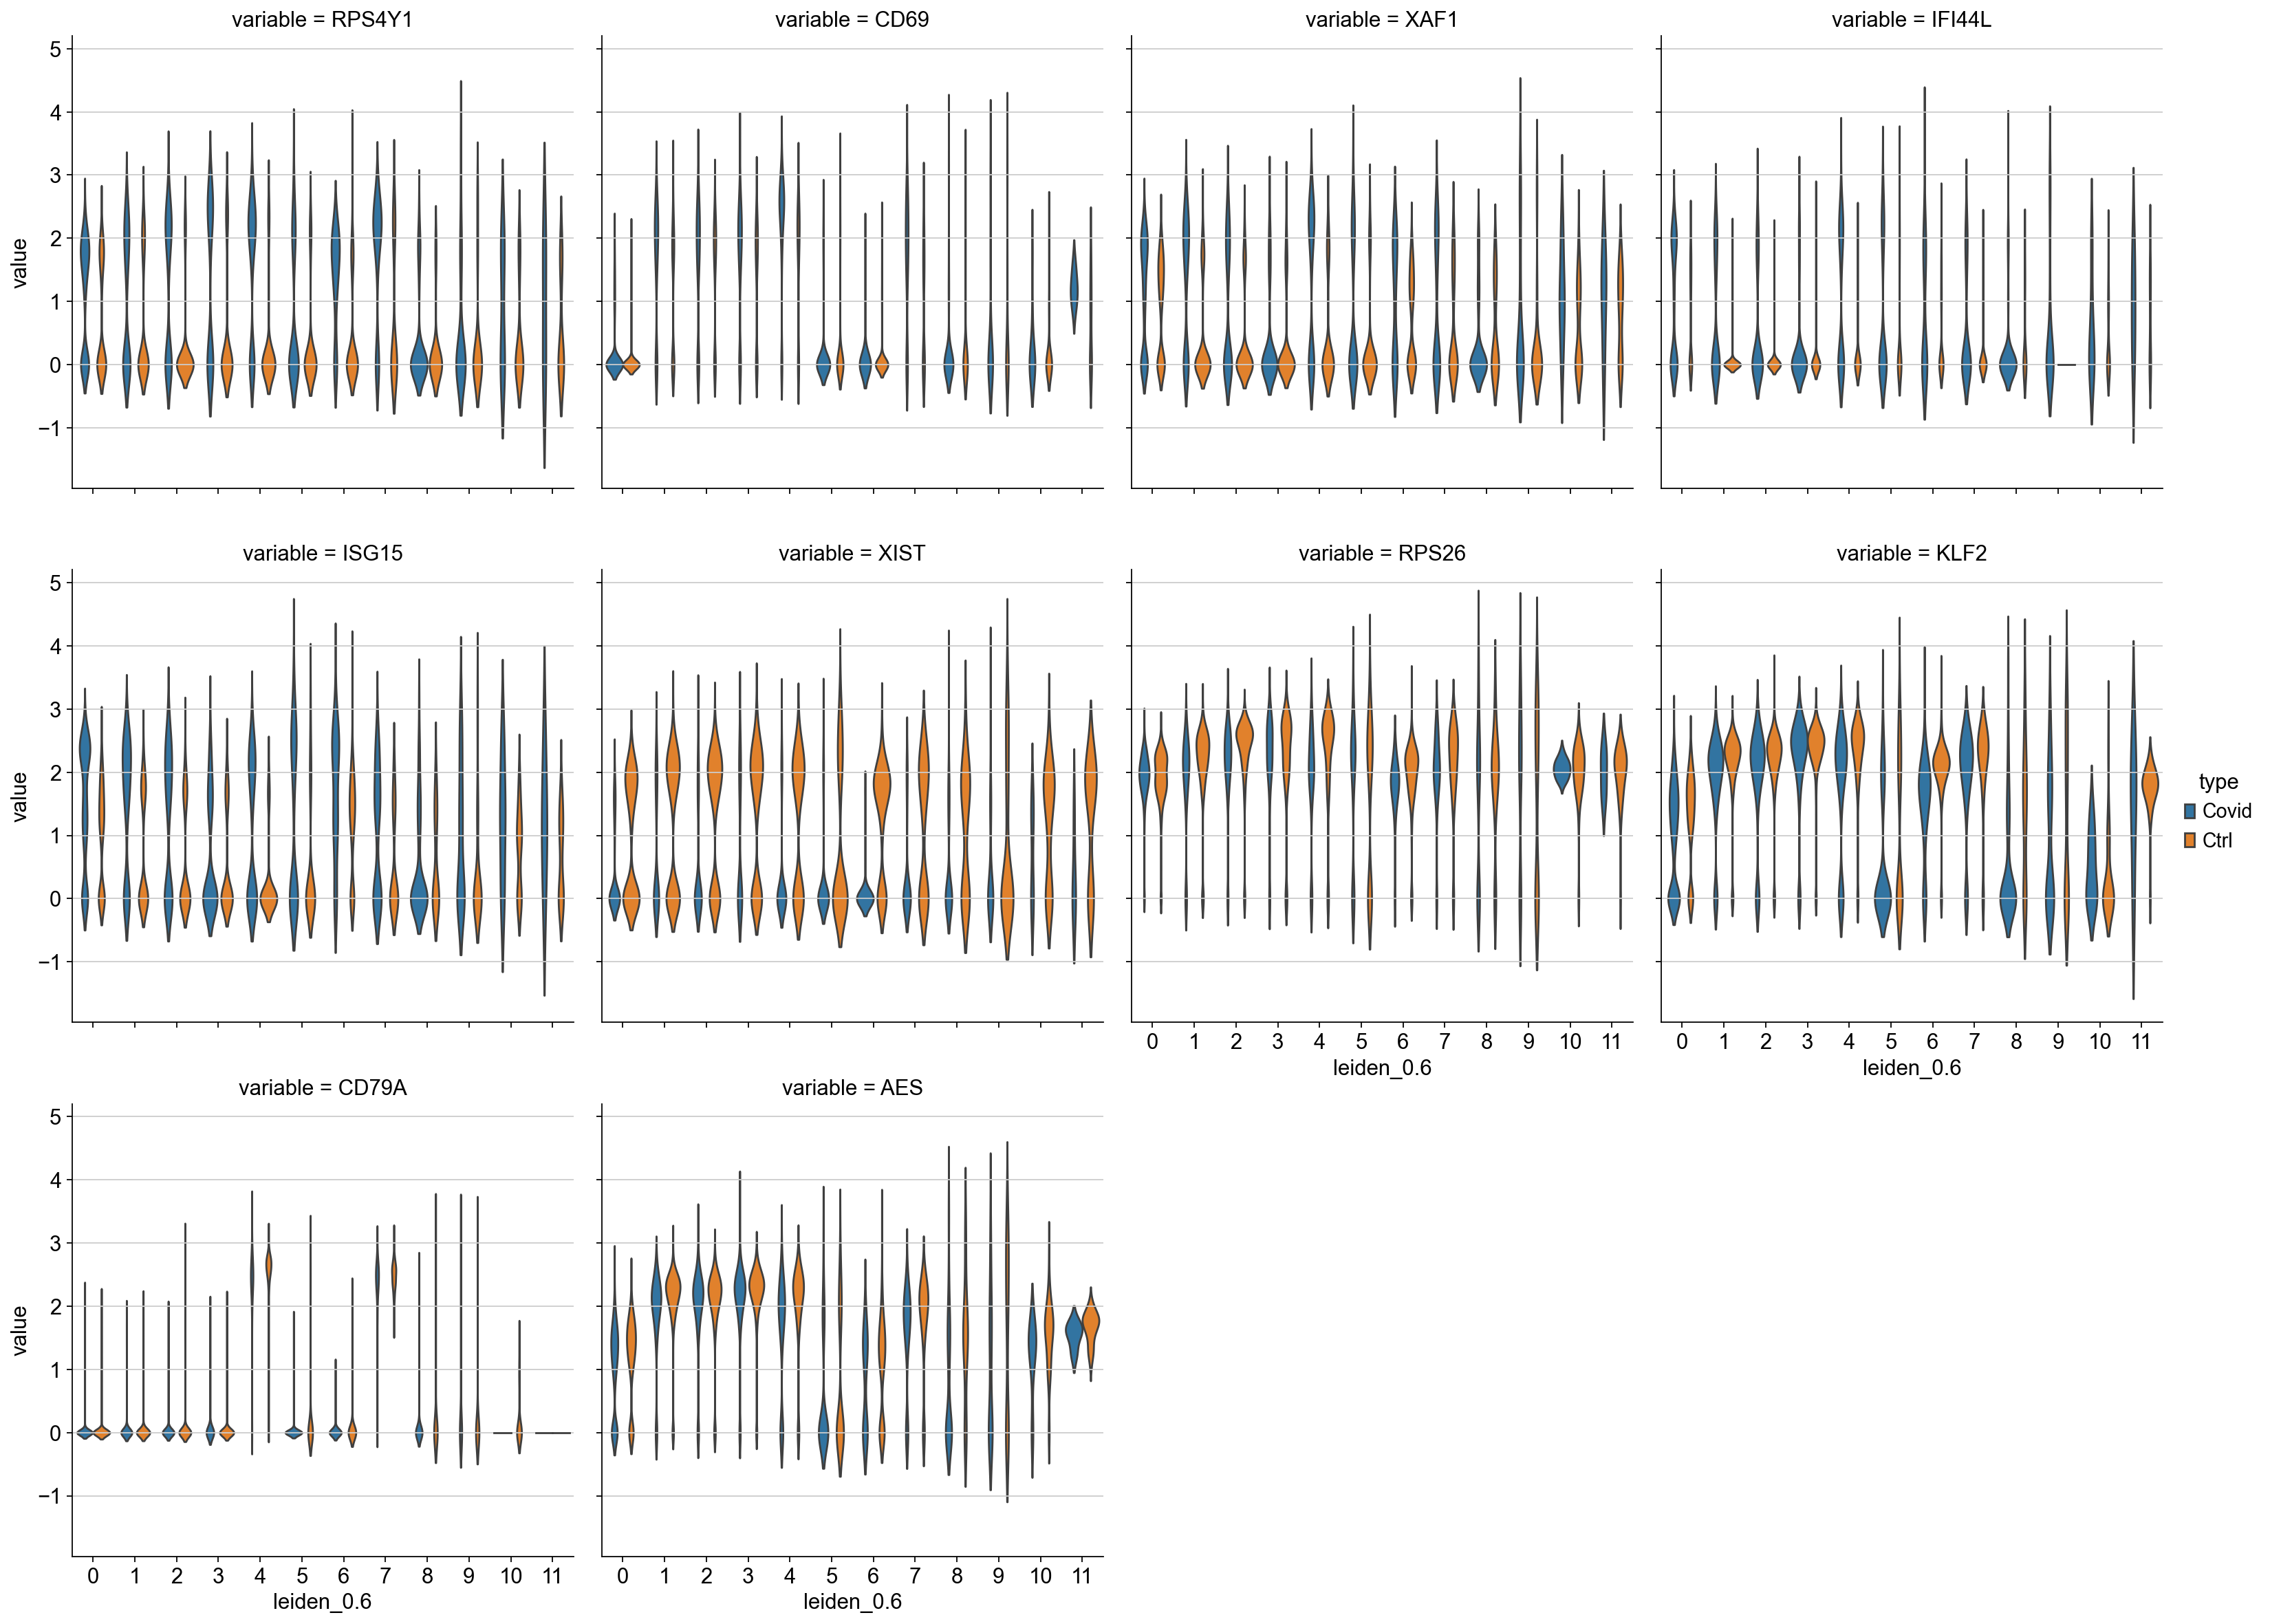

In [16]:
#| label: condition-vln-all
import seaborn as sns

genes1 = sc.get.rank_genes_groups_df(cl1, group='Covid', key='wilcoxon')['names'][:5]
genes2 = sc.get.rank_genes_groups_df(cl1, group='Ctrl', key='wilcoxon')['names'][:5]
genes = genes1.tolist() +  genes2.tolist() 
df = sc.get.obs_df(adata, genes + ['leiden_0.6','type'], use_raw=True)
df2 = df.melt(id_vars=["leiden_0.6",'type'], value_vars=genes)

sns.catplot(x = "leiden_0.6", y = "value", hue = "type", kind = 'violin', col = "variable", data = df2, col_wrap=4, inner=None)

As you can see, we have many sex chromosome related genes among the top
DE genes. And if you remember from the QC lab, we have inbalanced sex
distribution among our subjects, so this is probably not related to
covid at all.

### Remove sex chromosome genes

To remove some of the bias due to inbalanced sex in the subjects we can
remove the sex chromosome related genes.

In [17]:
#| label: sex-genes

annot_file = 'data/covid/results/gene_annotations_pybiomart.csv'

if not os.path.exists(annot_file):
    annot = sc.queries.biomart_annotations("hsapiens", ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"] ).set_index("external_gene_name")
    annot.to_csv(annot_file)
else:
    annot = pd.read_csv(annot_file, index_col=0)

chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrX_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "X"])

sex_genes = chrY_genes.union(chrX_genes)
print(len(sex_genes))
all_genes = cl1.var.index.tolist()
print(len(all_genes))

keep_genes = [x for x in all_genes if x not in sex_genes]
print(len(keep_genes))

cl1 = cl1[:,keep_genes]

134
3984
3850


Rerun differential expression.

ranking genes
    finished (0:00:00)


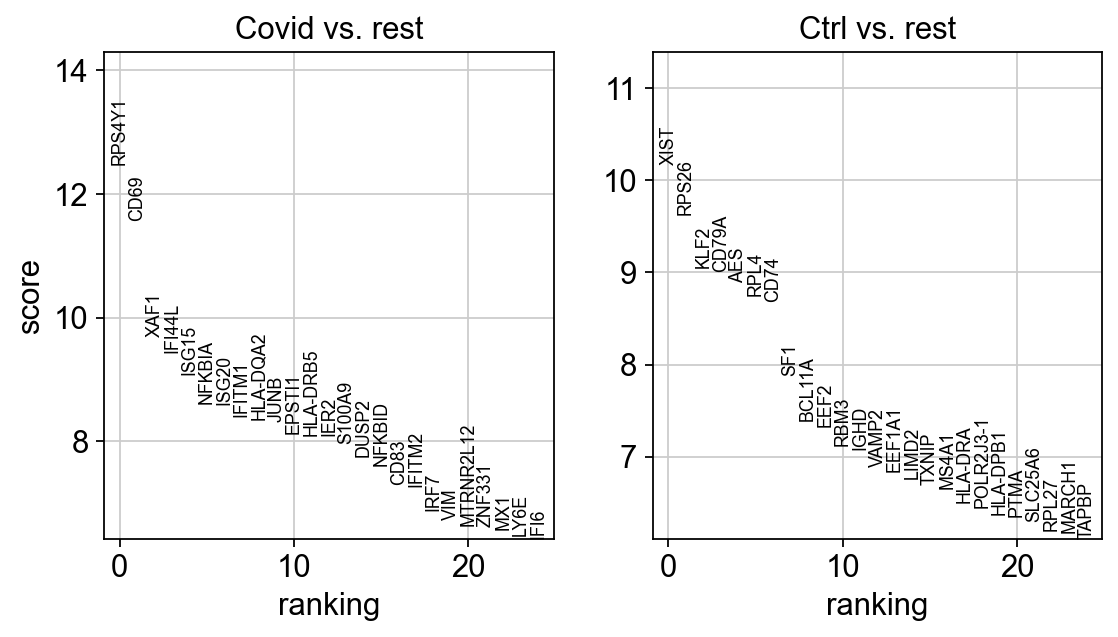

In [18]:
#| label: markers-nosex
sc.tl.rank_genes_groups(cl1, 'type', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(cl1, n_genes=25, sharey=False, key="wilcoxon")

Now at least we do not have the sex chromosome genes as DE but still,
some of the differences between patient and control could still be
related to sex.

### Patient batch effects

When we are testing for Covid vs Control we are running a DGE test for 4
vs 4 individuals. That will be very sensitive to sample differences
unless we find a way to control for it. So first, lets check how the top
DGEs are expressed in that cluster, across the individuals:

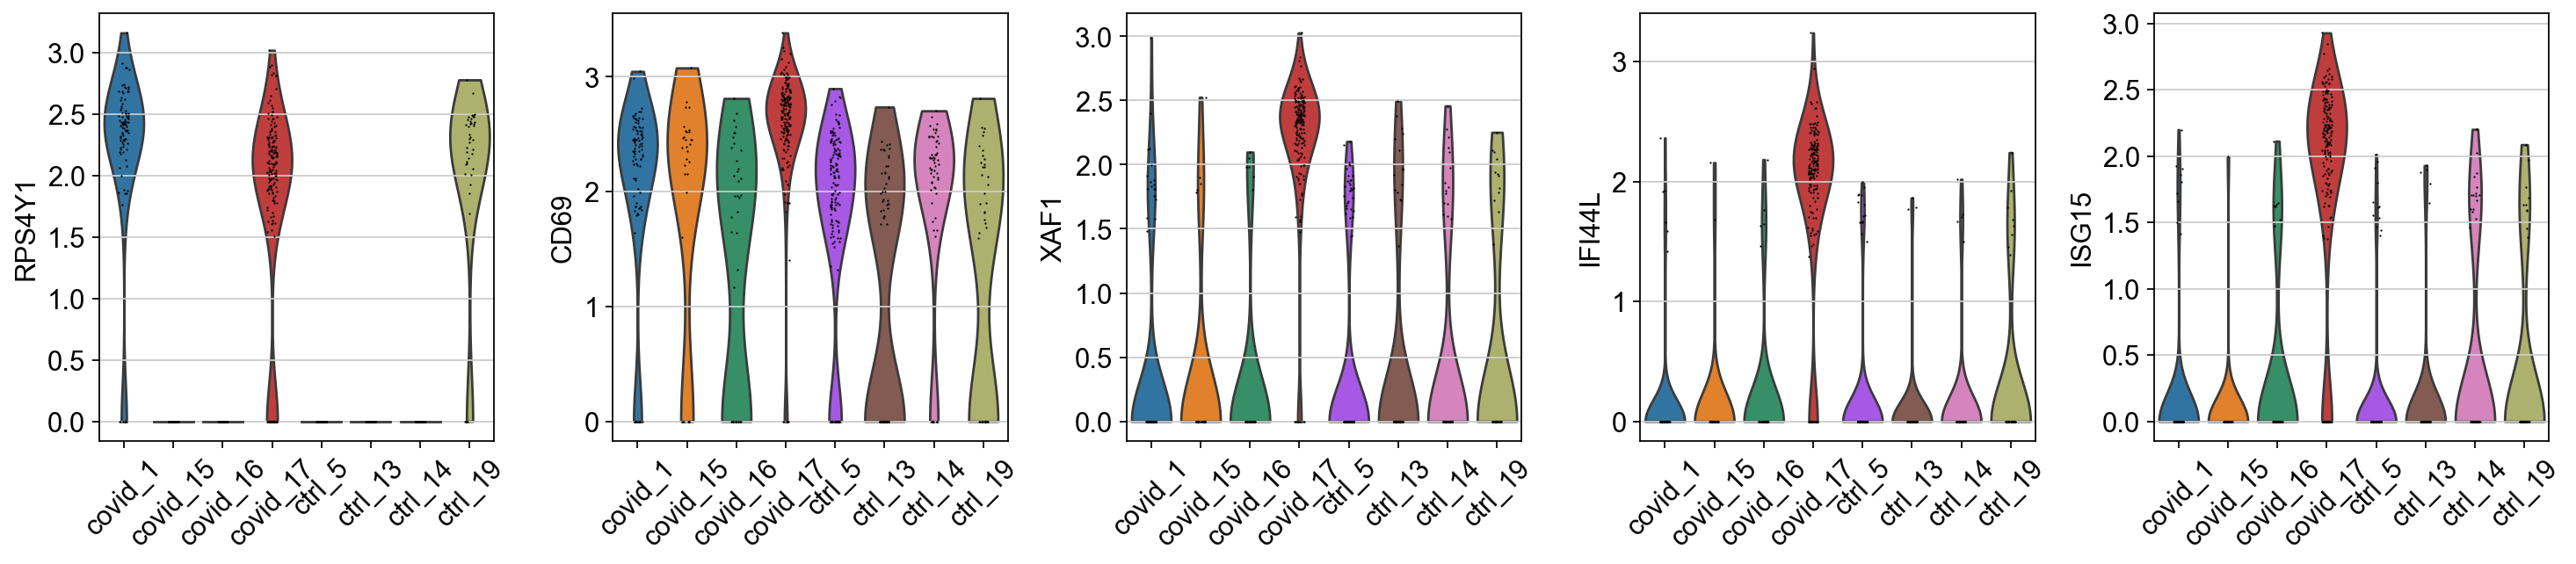

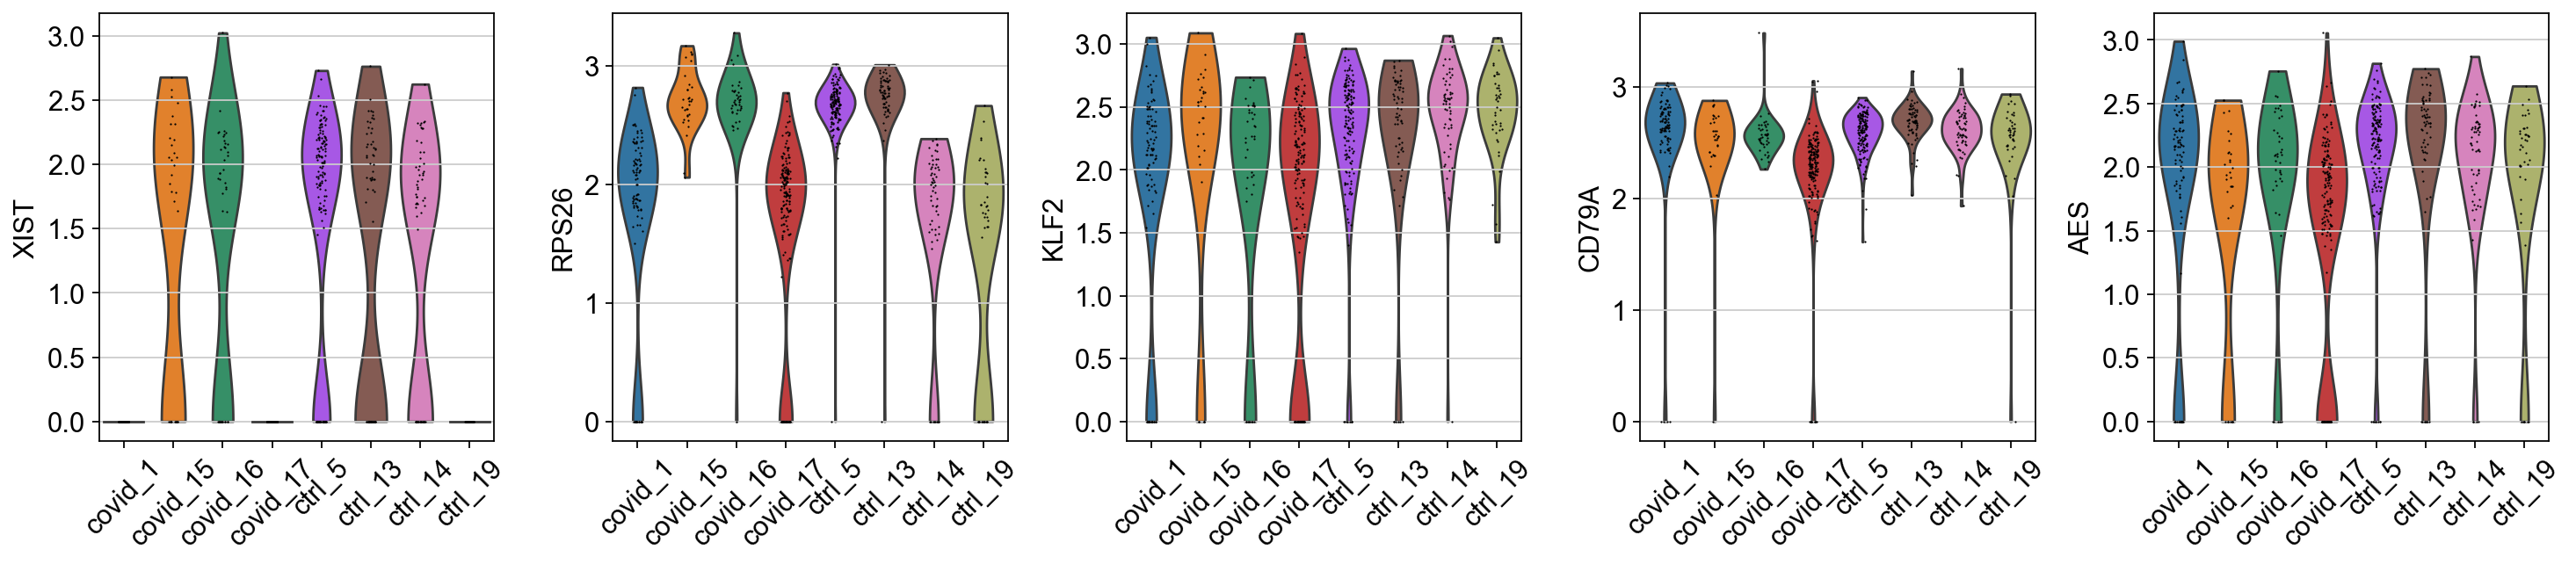

In [19]:
#| label: vln-batch
genes1 = sc.get.rank_genes_groups_df(cl1, group='Covid', key='wilcoxon')['names'][:5]
genes2 = sc.get.rank_genes_groups_df(cl1, group='Ctrl', key='wilcoxon')['names'][:5]
genes = genes1.tolist() +  genes2.tolist() 

sc.pl.violin(cl1, genes1, groupby='sample', rotation=45)
sc.pl.violin(cl1, genes2, groupby='sample', rotation=45)

As you can see, many of the genes detected as DGE in Covid are unique to
one or 2 patients.

We can also plot the top Covid and top Ctrl genes as a dotplot:

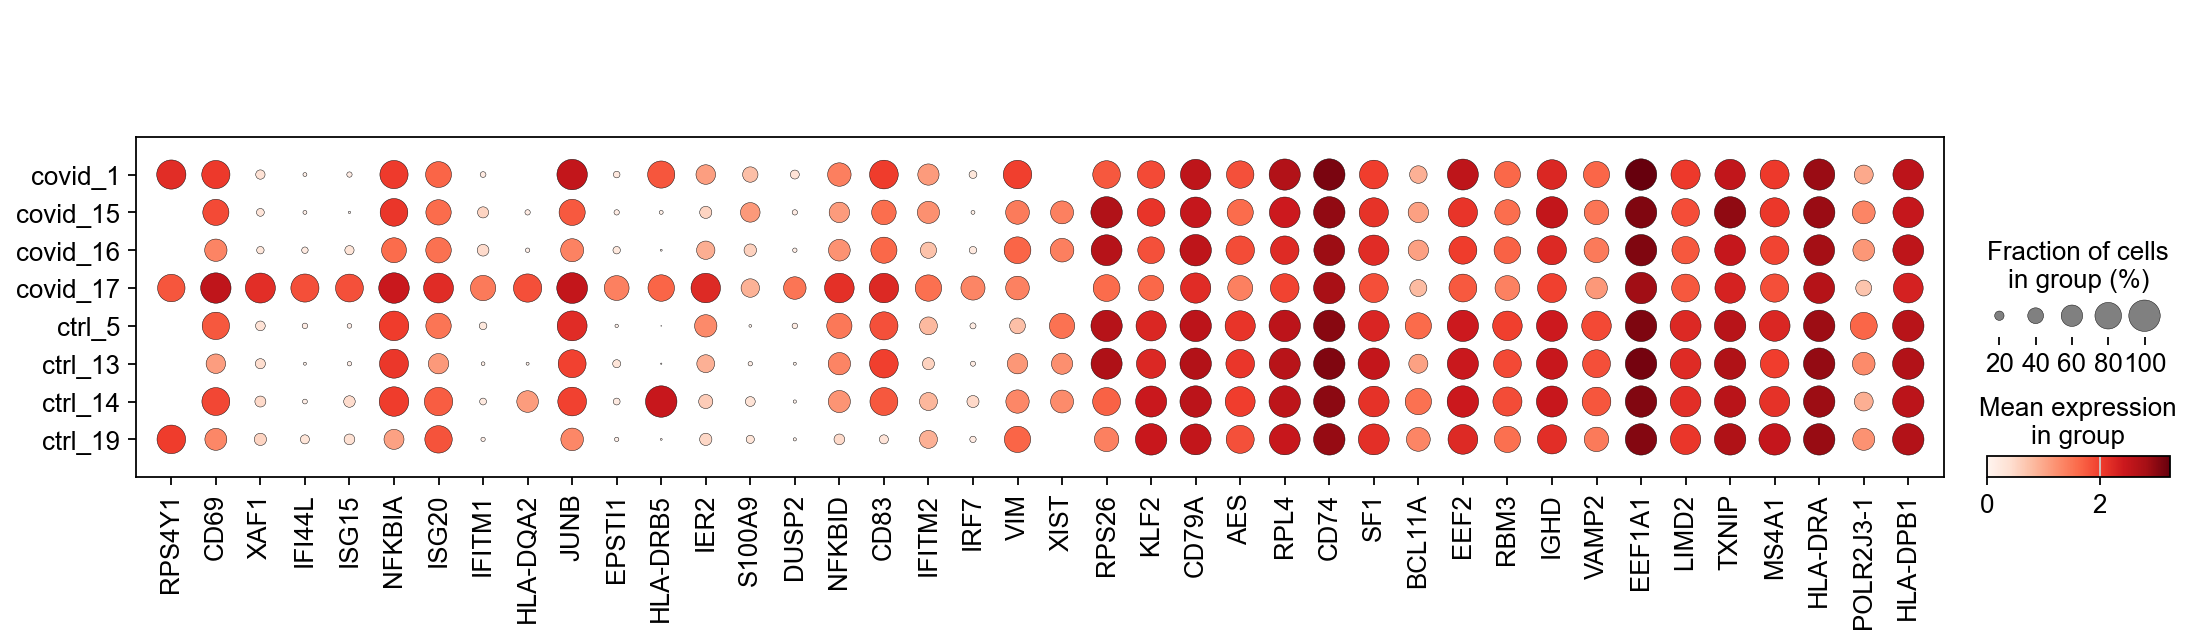

In [20]:
#| label: dotplot-batch
genes1 = sc.get.rank_genes_groups_df(cl1, group='Covid', key='wilcoxon')['names'][:20]
genes2 = sc.get.rank_genes_groups_df(cl1, group='Ctrl', key='wilcoxon')['names'][:20]
genes = genes1.tolist() +  genes2.tolist() 

sc.pl.dotplot(cl1,genes, groupby='sample')

Clearly many of the top Covid genes are only high in the covid_17
sample, and not a general feature of covid patients.

This is also the patient with the highest number of cells in this
cluster:

In [21]:
#| label: count-cells
cl1.obs['sample'].value_counts()

sample
covid_17    181
ctrl_5      153
covid_1      96
ctrl_13      68
ctrl_14      61
ctrl_19      42
covid_16     41
covid_15     32
Name: count, dtype: int64

### Subsample

So one obvious thing to consider is an equal amount of cells per
individual so that the DGE results are not dominated by a single sample.

So we will downsample to an equal number of cells per sample, in this
case 34 cells per sample as it is the lowest number among all samples

In [22]:
#| label: subsample-clusters
target_cells = 37

tmp = [cl1[cl1.obs['sample'] == s] for s in cl1.obs['sample'].cat.categories]

for dat in tmp:
    if dat.n_obs > target_cells:
            sc.pp.subsample(dat, n_obs=target_cells)

cl1_sub = tmp[0].concatenate(*tmp[1:])

cl1_sub.obs['sample'].value_counts()

sample
covid_1     37
covid_16    37
covid_17    37
ctrl_5      37
ctrl_13     37
ctrl_14     37
ctrl_19     37
covid_15    32
Name: count, dtype: int64

ranking genes
    finished (0:00:00)


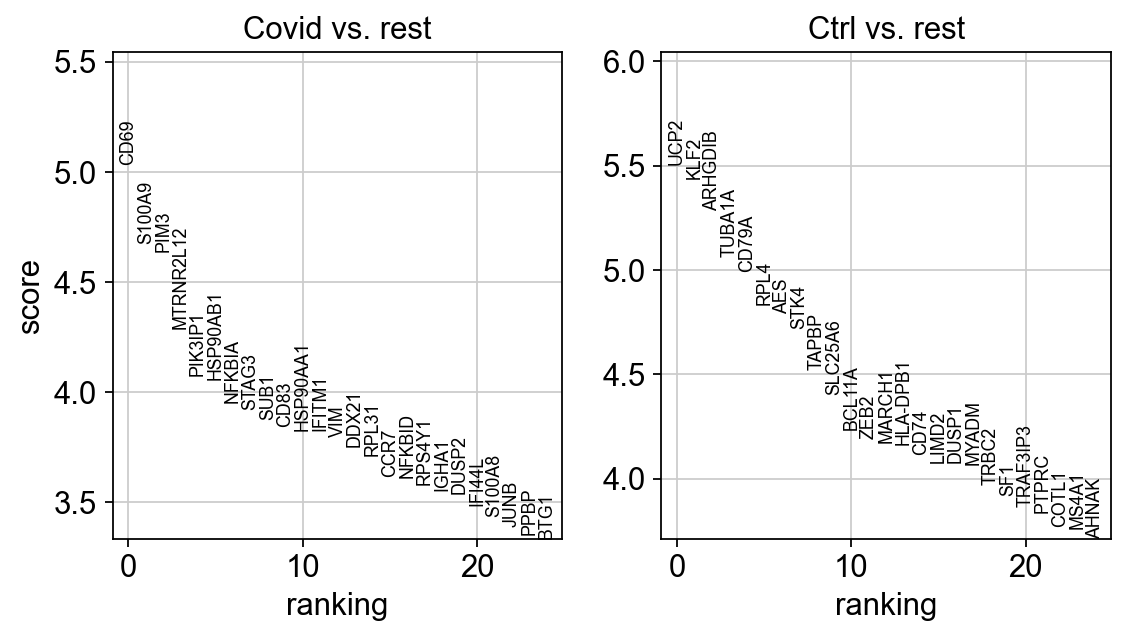

In [23]:
#| label: markers-sub
sc.tl.rank_genes_groups(cl1_sub, 'type', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(cl1_sub, n_genes=25, sharey=False, key="wilcoxon")

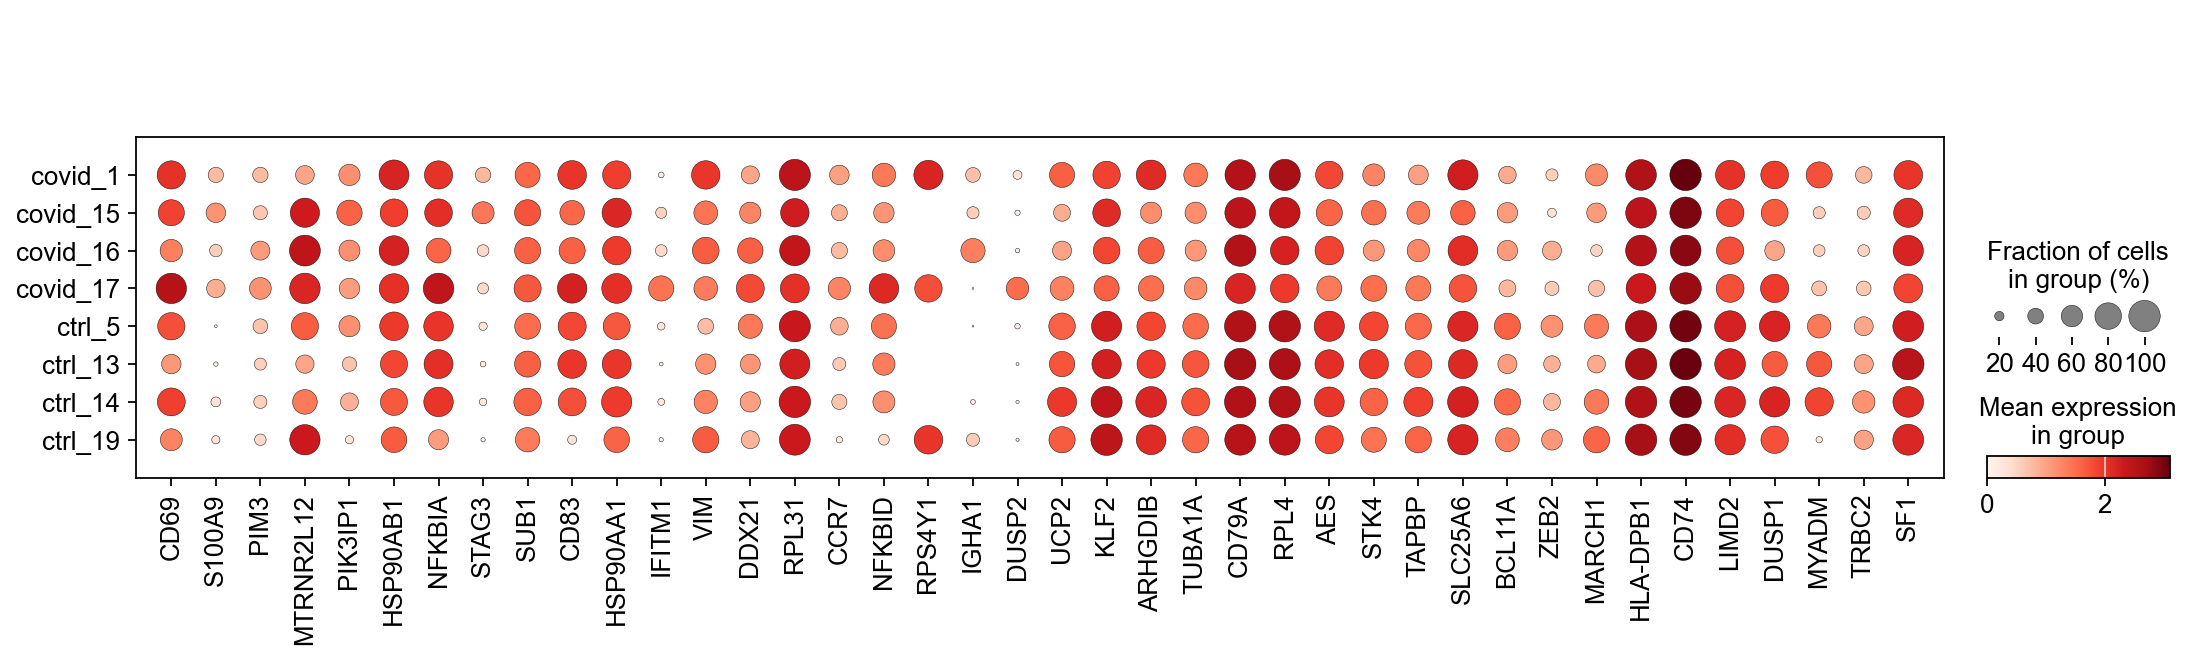

In [24]:
#| label: dotplot-sub
genes1 = sc.get.rank_genes_groups_df(cl1_sub, group='Covid', key='wilcoxon')['names'][:20]
genes2 = sc.get.rank_genes_groups_df(cl1_sub, group='Ctrl', key='wilcoxon')['names'][:20]
genes = genes1.tolist() +  genes2.tolist() 

sc.pl.dotplot(cl1,genes, groupby='sample')

It looks much better now. But if we look per subject you can see that we
still have some genes that are dominated by a single patient. Still, it
is often a good idea to control the number of cells from each sample
when doing differential expression.

There are many different ways to try and resolve the issue of patient
batch effects, however most of them require R packages. These can be run
via rpy2 as is demonstraded in this compendium:
https://www.sc-best-practices.org/conditions/differential_gene_expression.html

However, we have not included it here as of now. So please have a look
at the patient batch effect section in the seurat DGE tutorial where we
run EdgeR on pseudobulk and MAST with random effect:
https://nbisweden.github.io/workshop-scRNAseq/labs/seurat/seurat_05_dge.html

## Gene Set Analysis (GSA)

### Hypergeometric enrichment test

Having a defined list of differentially expressed genes, you can now
look for their combined function using hypergeometric test.

In [25]:
#| label: gsea-genesets
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and

Get the significant DEGs for the Covid patients.

In [26]:
#| label: get-dges
#?gseapy.enrichr
glist = sc.get.rank_genes_groups_df(cl1_sub, group='Covid', key='wilcoxon', log2fc_min=0.25, pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
print(len(glist))

6


In [27]:
#| label: gsea
enr_res = gseapy.enrichr(gene_list=glist, organism='Human', gene_sets='GO_Biological_Process_2018', cutoff = 0.5)
enr_res.results.head()

Gene_set  \
0  GO_Biological_Process_2018   
1  GO_Biological_Process_2018   
2  GO_Biological_Process_2018   
3  GO_Biological_Process_2018   
4  GO_Biological_Process_2018   

                                                Term Overlap   P-value  \
0  negative regulation of transforming growth fac...     1/6  0.001799   
1  negative regulation of phospholipid metabolic ...     1/6  0.001799   
2                 leukocyte aggregation (GO:0070486)     1/7  0.002098   
3  positive regulation of protein localization to...     1/8  0.002398   
4        virion attachment to host cell (GO:0019062)     1/9  0.002697   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.028515            0                     0  799.560000   
1          0.028515            0                     0  799.560000   
2          0.028515            0                     0  666.266667   
3          0.028515            0                     0  571.057143   
4          0.028515            0                     0  499.650000   

   Combined Score     Genes  
0     5053.709148  HSP90AB1  
1     5053.709148   PIK3IP1  
2     4108.590826    S100A9  
3     3445.289983  HSP90AB1  
4     2955.689739  HSP90AB1

Some databases of interest:\
`GO_Biological_Process_2017b``KEGG_2019_Human``KEGG_2019_Mouse``WikiPathways_2019_Human``WikiPathways_2019_Mouse`\
You visualize your results using a simple barplot, for example:

<Axes: title={'center': 'GO_Biological_Process_2018'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

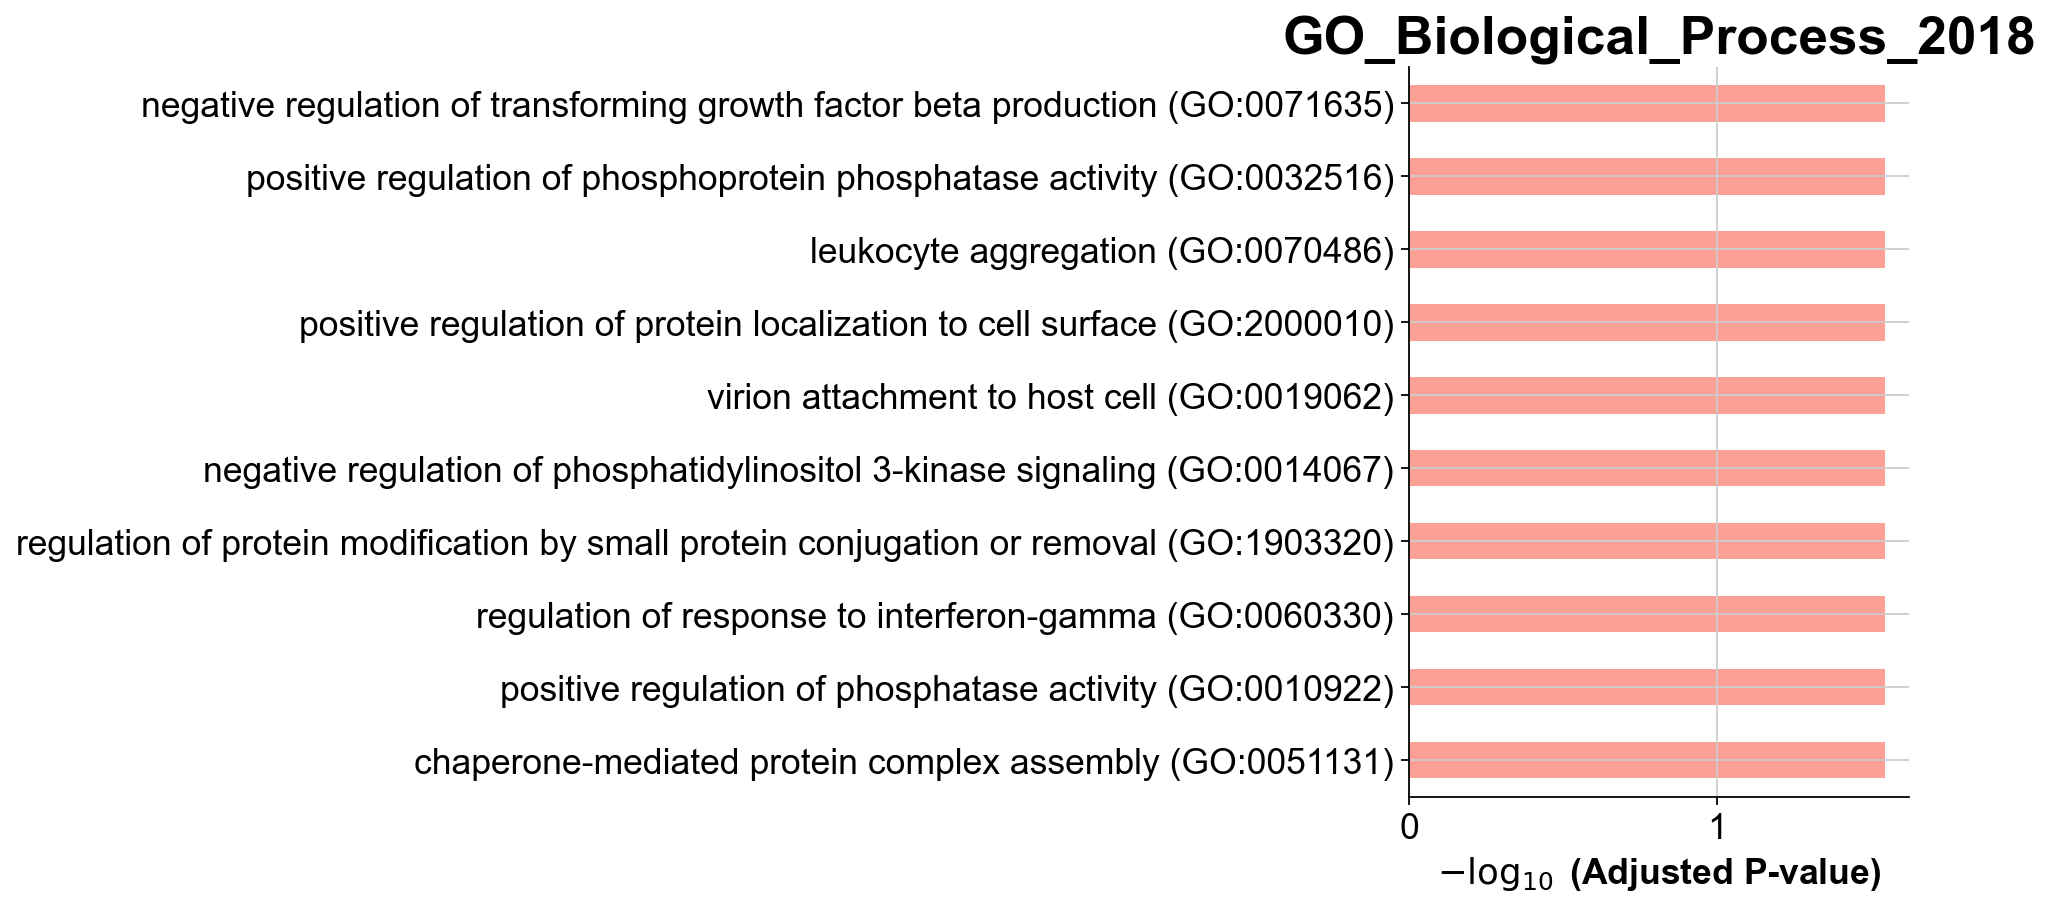

In [28]:
#| label: plot-gsea
gseapy.barplot(enr_res.res2d,title='GO_Biological_Process_2018')

## Gene Set Enrichment Analysis (GSEA)

Besides the enrichment using hypergeometric test, we can also perform
gene set enrichment analysis (GSEA), which scores ranked genes list
(usually based on fold changes) and computes permutation test to check
if a particular gene set is more present in the Up-regulated genes,
among the DOWN_regulated genes or not differentially regulated.

We need a table with all DEGs and their log foldchanges. However, many
lowly expressed genes will have high foldchanges and just contribue
noise, so also filter for expression in enough cells.

In [29]:
#| label: gene-rank
gene_rank = sc.get.rank_genes_groups_df(cl1_sub, group='Covid', key='wilcoxon')[['names','logfoldchanges']]
gene_rank.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)

# calculate_qc_metrics will calculate number of cells per gene
sc.pp.calculate_qc_metrics(cl1, percent_top=None, log1p=False, inplace=True)

# filter for genes expressed in at least 30 cells.
gene_rank = gene_rank[gene_rank['names'].isin(cl1.var_names[cl1.var.n_cells_by_counts>30])]

gene_rank

names  logfoldchanges
151         PF4       28.017332
210    MTRNR2L1       27.951775
316       CXCL8       27.453955
380        G0S2       27.165596
682        CCL3       26.821484
...         ...             ...
17544      CSTA      -25.910336
17546      MIAT      -25.982347
17538     TTC34      -26.053516
17901     CEP41      -26.089569
17902      REM2      -26.238188

[3850 rows x 2 columns]

Once our list of genes are sorted, we can proceed with the enrichment
itself. We can use the package to get gene set from the Molecular
Signature Database (MSigDB) and select KEGG pathways as an example.

In [30]:
#| label: gsea-genesets2
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and

Next, we will run GSEA. This will result in a table containing
information for several pathways. We can then sort and filter those
pathways to visualize only the top ones. You can select/filter them by
either `p-value` or normalized enrichment score (`NES`).

In [31]:
#| label: gsea-rank
res = gseapy.prerank(rnk=gene_rank, gene_sets='KEGG_2021_Human')

terms = res.res2d.Term
terms[:10]

2025-05-23 17:26:55,432 [WARNING] Duplicated values found in preranked stats: 13.74% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


0                       Sphingolipid signaling pathway
1                    T cell receptor signaling pathway
2             C-type lectin receptor signaling pathway
3    PD-L1 expression and PD-1 checkpoint pathway i...
4                                  Cellular senescence
5                                  Cholinergic synapse
6                     Th1 and Th2 cell differentiation
7                              IL-17 signaling pathway
8                                        Leishmaniasis
9       Growth hormone synthesis, secretion and action
Name: Term, dtype: object

[<Axes: xlabel='Gene Rank', ylabel='Ranked metric'>,
 <Axes: >,
 <Axes: >,
 <Axes: ylabel='Enrichment Score'>]

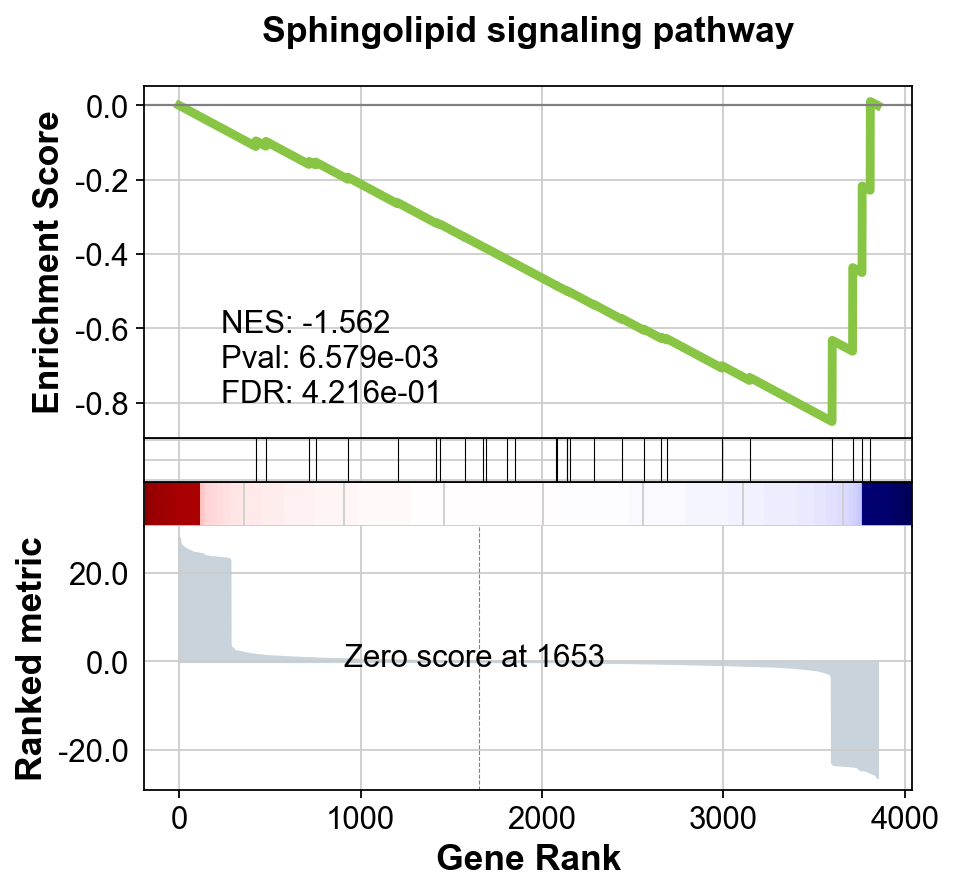

In [32]:
#| label: plot-gsea-rank
gseapy.gseaplot(rank_metric=res.ranking, term=terms[0], **res.results[terms[0]])

<div>

> **Discuss**
>
> Which KEGG pathways are upregulated in this cluster? Which KEGG
> pathways are dowregulated in this cluster? Change the pathway source
> to another gene set (e.g. CP:WIKIPATHWAYS or CP:REACTOME or
> CP:BIOCARTA or GO:BP) and check the if you get similar results?

</div>

Finally, let's save the integrated data for further analysis.

In [33]:
#| label: save
adata.write_h5ad('./data/covid/results/scanpy_covid_qc_dr_scanorama_cl_dge.h5ad')

## Session info

```{=html}
<details>
```
```{=html}
<summary>
```
Click here
```{=html}
</summary>
```

In [34]:
#| label: session
sc.logging.print_versions()

pandas	2.2.3
numpy	2.2.5
scanpy	1.11.1
gseapy	1.1.8
matplotlib	3.10.3
anndata	0.11.4
matplotlib-venn	1.1.2
seaborn	0.13.2
----	----
parso	0.8.4
attrs	24.3.0
requests	2.32.3
pytz	2025.2
urllib3	2.3.0
scipy	1.15.3
h5py	3.13.0
threadpoolctl	3.6.0
scikit-learn	1.5.2
pyparsing	3.2.3
future	1.0.0
ipython	9.1.0
defusedxml	0.7.1
jupyter_client	8.6.3
pure-eval	0.2.2
matplotlib-inline	0.1.6
cattrs	24.1.3
typing_extensions	4.12.2
jedi	0.19.2
idna	3.7
traitlets	5.14.3
url-normalize	2.2.1
six	1.17.0
pillow	11.2.1
Pygments	2.19.1
debugpy	1.8.11
patsy	1.0.1
pycparser	2.21
packaging	24.2
Cython	3.1.0
Brotli	1.0.9
statsmodels	0.14.4
certifi	2025.4.26 (2025.04.26)
cycler	0.12.1
natsort	8.4.0
igraph	0.11.8
python-dateutil	2.9.0.post0
ipykernel	6.29.5
executing	0.8.3
numba	0.61.2
decorator	5.1.1
jupyter_core	5.7.2
leidenalg	0.10.2
cffi	1.17.1
joblib	1.5.0
charset-normalizer	3.3.2
platformdirs	4.3.7
texttable	1.7.0
llvmlite	0.44.0
psutil	5.9.0
session-info2	0.1.2
prompt-toolkit	3.0.43
appnope	0.1.3
kiwisolver	1.4.8
pybiomart	0.2.0
PySocks	1.7.1
PyYAML	6.0.2
setuptools	78.1.1
wcwidth	0.2.5
legacy-api-wrap	1.4.1
tornado	6.4.2
pyzmq	26.2.0
asttokens	3.0.0
stack-data	0.2.0
requests-cache	1.2.1
comm	0.2.1
----	----
Python	3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 12:55:12) [Clang 14.0.6 ]
OS	macOS-15.5-arm64-arm-64bit
CPU	12 logical CPU cores, arm
GPU	No GPU found
Updated	2025-05-23 09:27

```{=html}
</details>
```

## archive

In [37]:
!jupyter nbconvert --output-dir archive --to markdown --no-input scanpy_05_dge.ipynb

[NbConvertApp] Converting notebook scanpy_05_dge.ipynb to markdown
[NbConvertApp] Support files will be in scanpy_05_dge_files/
[NbConvertApp] Writing 41885 bytes to archive/scanpy_05_dge.md
